In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Data Mining/Data/'

In [4]:
df_full = pd.read_csv(data_path+'df2022_WiClass.csv')

In [5]:
#df_full = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Mining/Data/df2022_WiClass.csv')
#https://drive.google.com/file/d/1QXnpsolrfLIkOlwSNYUgWz1j-Q4omiSO/view?usp=drive_link
df_full = pd.read_csv('/content/drive/MyDrive/df2022_WiClass.csv')
Features = ['PREGNANT', 'WEIGHT2', 'HEIGHT3', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON',
            'HADMAM', 'HOWLONG', 'CERVSCRN', 'CRVCLCNC', 'CRVCLPAP', 'CRVCLHPV', 'HADHYST2', 'HADSIGM4',
            'COLNSIGM', 'COLNTES1', 'SIGMTES1', 'LASTSIG4', 'COLNCNCR', 'VIRCOLO1', 'VCLNTES2', 'SMALSTOL',
            'STOLTEST', 'STOOLDN2', 'BLDSTFIT', 'SDNATES1', 'SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2',
            'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'LCSCTSC1', 'LCSSCNCR', 'LCSCTWHN', 'ALCDAY4', 'AVEDRNK3',
            'DRNK3GE5', 'MAXDRNKS', 'FLUSHOT7', 'FLSHTMY3', 'PNEUVAC4', 'TETANUS1', 'HIVTST7', 'HIVTSTD3',
            'HIVRISK5', 'COVIDPOS', 'COVIDSMP', 'COVIDPRM', 'PDIABTS1', 'PREDIAB2', 'DIABTYPE', 'INSULIN1',
            'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'DIABEDU1', 'FEETSORE', 'TOLDCFS', 'HAVECFS', 'WORKCFS',
            'IMFVPLA3','Class']
df = df_full[Features]

In [6]:
df.head()

,PREGNANT,WEIGHT2,HEIGHT3,DEAF,BLIND,DECIDE,DIFFWALK,DIFFDRES,DIFFALON,HADMAM,...,CHKHEMO3,EYEEXAM1,DIABEYE1,DIABEDU1,FEETSORE,TOLDCFS,HAVECFS,WORKCFS,IMFVPLA3,Class
0,NaN,140.0,511.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mild CD
1,NaN,170.0,502.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No CD
2,NaN,7777.0,506.0,2.0,2.0,1.0,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mild CD
3,NaN,170.0,510.0,2.0,2.0,2.0,7.0,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No CD
4,NaN,225.0,510.0,2.0,2.0,2.0,1.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No CD


In [7]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2, pvalue, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [8]:
#@title Function for binary variable exploration
def explore_binary(df, feature, include_refused=False):
  print(f'There are {df[feature].isna().sum()} missing values, {np.sum(df[feature]==7)} not sure, {np.sum(df[feature]==9)} refused')
  if np.sum(~df[feature].isna()) == 0:
    print("No valid information")
  else:
    subdf = df[[feature, 'Class']]
    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})
    if not include_refused:
      subdf = subdf[(subdf[feature] == 1) | (subdf[feature] == 2)]
      subdf[feature] = subdf[feature].replace({1:'Yes', 2: 'No'})

      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = ['Yes', 'No']
      frequencies.reindex(idx_order)
      frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

    else:
      subdf = subdf[(subdf[feature] == 1) | (subdf[feature] == 2)| (subdf[feature] == 7)| (subdf[feature] == 9)]
      subdf[feature] = subdf[feature].replace({1:'Yes', 2: 'No', 7: 'Not Sure', 9: 'Refused'})

      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped.fillna(0, inplace=True)
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = ['Yes', 'No', 'Not Sure', 'Refused']
      frequencies.reindex(idx_order)
      frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

In [9]:
#explore_binary(df, 'SDHBILLS', include_refused=False)

In [10]:
#@title Function for categorical variable exploration
# mapping = {1:'Always', 2:"Usually",..., 7:"Not Sure", 9:"Refused"}
def explore_cat(df, feature, mapping, include_refused=False):
  subdf = df[[feature, 'Class']]
  subdf[feature] = subdf[feature].replace(mapping)
  print(f'There are {df[feature].isna().sum()} missing values, {np.sum(subdf[feature]=="Not Sure")} not sure values, {np.sum(subdf[feature]=="Refused")} refused values')
  if np.sum(~df[feature].isna()) == 0:
    print("No valid information")

  else:
    subdf.dropna(subset = [feature], inplace=True)
    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})

    if not include_refused:
      subdf = subdf[~((subdf[feature] == 'Not Sure') | (subdf[feature] == 'Refused'))]

      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = list(mapping.values())[:-2]
      frequencies.reindex(idx_order)
      frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

    else:
      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped.fillna(0, inplace=True)
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = list(mapping.values())
      frequencies.reindex(idx_order)
      frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

In [11]:
# mapping = {1:"Gay", 2: "Straight", 3: "Bi", 4:"Others", 7: "Not Sure", 9: "Refused"}
mapping = {1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native Hawaiian', 6: 'American Indian', 7: 'Mixed', 8:'Others',
            77: "Not Sure", 99: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
#feature = 'RRCLASS3'

#explore_cat(df_full, feature, mapping, include_refused=False)

In [12]:
#@title Function for continuous variable exploration
def explore_cts(df, feature, none=88, not_sure=77, refused=99):
  subdf = df[[feature, 'Class']]
  print(f'There are {subdf[feature].isna().sum()} missing values, {np.sum(subdf[feature]==not_sure)} not sure values, {np.sum(subdf[feature]==refused)} refused values')

  if np.sum(~subdf[feature].isna()) == 0:
    print("No valid information")

  else:
    subdf.dropna(subset=[feature], inplace=True)
    subdf = subdf[~((subdf[feature]==not_sure) | (subdf[feature]==refused))]
    subdf[feature] = subdf[feature].replace(none, 0)

    desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
    desired_order2 = ['CD', 'No CD']

    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    sns.kdeplot(data=subdf[(subdf['Class']!='No CD')], x=feature, hue='Class', hue_order=desired_order,fill=True,
                common_norm=False, bw_adjust=2, ax=axes[0])
    axes[0].set_xlabel(f'{feature}', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title(f'Distribution of {feature} within different CD classes', fontsize=14)
    axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')

    sns.kdeplot(data=subdf, x=feature, hue='Binary Classification', hue_order=desired_order2,fill=True,
                common_norm=False, bw_adjust=2, ax=axes[1])
    axes[1].set_xlabel(f'{feature}', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title(f'Distribution of {feature} with and without CD', fontsize=14)
    axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')

    plt.tight_layout()
    plt.show()

    groups = [group[feature] for name, group in subdf[(subdf['Class']!='No CD')].groupby('Class')]
    f_statistic, p_value = f_oneway(*groups)

    print("p-value for multi-class classification is:", p_value)

    groups2 = [group[feature] for name, group in subdf.groupby('Binary Classification')]
    f_statistic, p_value2 = f_oneway(*groups2)

    print("p-value for binary classification:", p_value2)



In [13]:
#feature = 'MARIJAN1';

#explore_cts(df_full, feature, none=88, not_sure=98, refused=99)

In [14]:
df['PREGNANT'].unique()
# it is binary

array([nan,  2.,  9.,  1.,  7.])

There are 60686 missing values, 1 not sure, 12 refused


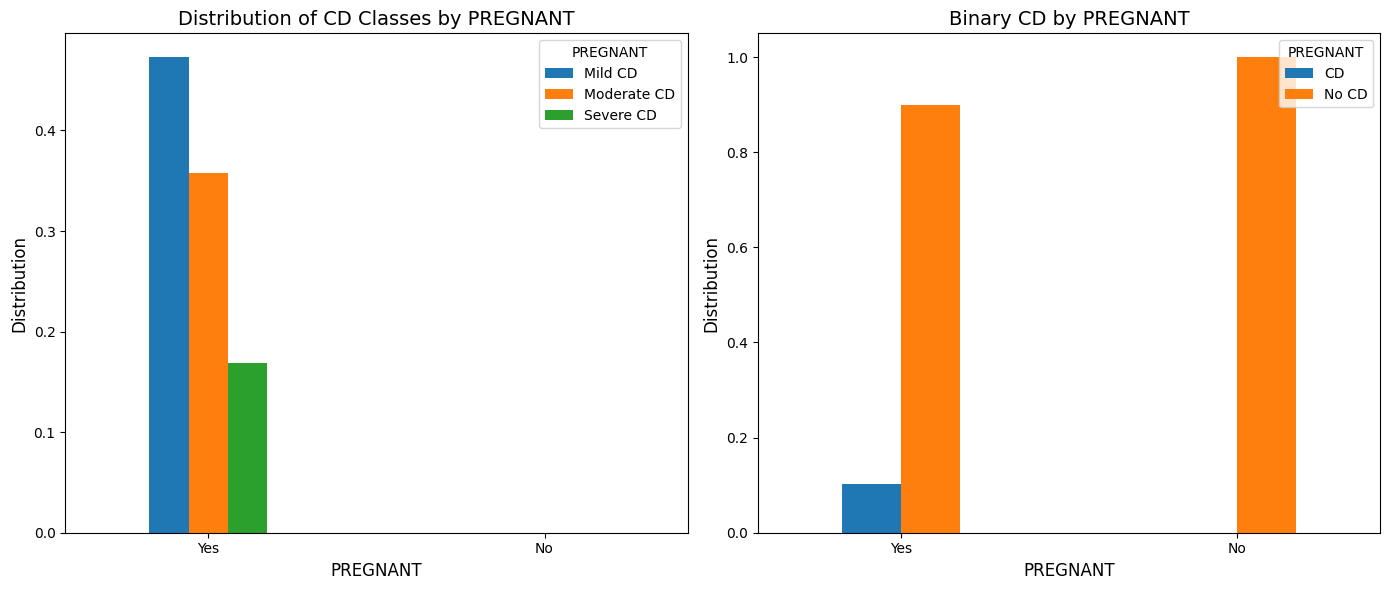

Cramers V for multi-class classification is: nan
Cramers V for binary classification is: 0.004848549925949328


<ipython-input-7-1bd085c0abcc>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


In [15]:
explore_binary(df, 'PREGNANT', include_refused=False)

In [16]:
df['WEIGHT2'].unique()
#continuous
#50 - 0776 ：Weight (pounds)
#7777 ： Don’t know/Not sure
#9023 - 9352 ： Weight (kilograms)；Notes: The initial ´9´ indicates this was a metric value.
#9999： Refused
#transform firstly


array([ 140.,  170., 7777.,  225.,  135.,  286.,  145.,  250.,  200.,
        130.,  132.,  162.,  260.,  189.,  218., 9999.,  178.,  175.,
        160.,  105.,  115.,  230.,  185.,  320.,  214.,  120.,  165.,
        161.,  125.,  191.,  280.,  182.,  220.,  100.,  190.,  150.,
        215.,  137.,  138.,  192.,  212.,  152.,  245.,  177.,  195.,
        180.,  205.,  134.,  240.,  103.,  155.,  248.,  268.,  154.,
        235.,  110.,  141.,  210.,  136.,  203.,  144.,  163.,  156.,
        270.,  102.,  148.,  204.,  263.,  184.,  127.,  290.,  143.,
        149.,   97.,  208.,  174.,  183.,  197.,  147.,  122.,  129.,
        124.,  151.,  275.,  159.,  131.,  139.,   90.,  112.,  274.,
        142.,  158.,  265.,  168.,  188.,  255.,  176.,  133.,  252.,
        202.,  209.,  123.,  193.,   91.,  186.,   93.,  247.,   98.,
        119.,  194.,  199.,  232.,  219.,  243.,  311.,  242.,  128.,
        312.,  107.,  206.,  257.,  285.,  153.,  216.,  169.,  157.,
        179.,  171.,

In [17]:
# 定义一个函数来处理重量转换
def process_weight(kg):
  kg=int(kg)
  if len(str(kg)) == 4:
    if 9023 <= kg <= 9352:
        kg_without_nine = int(str(kg)[1:])  # 去掉首位的'9'
        pounds = round(kg_without_nine * 2.20462)  # 转换千克到磅
        return pounds
  return kg  # 不在范围内的保持不变

# 应用这个函数到DataFrame的Weight列
df['WEIGHT2']= df['WEIGHT2'].apply(process_weight)


In [18]:
df['WEIGHT2']

0         140
1         170
2        7777
3         170
4         225
         ... 
63625    7777
63626     185
63627     185
63628     168
63629     225
Name: WEIGHT2, Length: 63630, dtype: int64

In [19]:
df['WEIGHT2'] = df['WEIGHT2'].fillna(8888)

In [20]:
df['WEIGHT2'].unique()

array([ 140,  170, 7777,  225,  135,  286,  145,  250,  200,  130,  132,
        162,  260,  189,  218, 9999,  178,  175,  160,  105,  115,  230,
        185,  320,  214,  120,  165,  161,  125,  191,  280,  182,  220,
        100,  190,  150,  215,  137,  138,  192,  212,  152,  245,  177,
        195,  180,  205,  134,  240,  103,  155,  248,  268,  154,  235,
        110,  141,  210,  136,  203,  144,  163,  156,  270,  102,  148,
        204,  263,  184,  127,  290,  143,  149,   97,  208,  174,  183,
        197,  147,  122,  129,  124,  151,  275,  159,  131,  139,   90,
        112,  274,  142,  158,  265,  168,  188,  255,  176,  133,  252,
        202,  209,  123,  193,   91,  186,   93,  247,   98,  119,  194,
        199,  232,  219,  243,  311,  242,  128,  312,  107,  206,  257,
        285,  153,  216,  169,  157,  179,  171,  164,   85,  166,  298,
        114,  198,  118,  172,  146,  106,  221,  108,  116,  277,  234,
        173,  217,  207,  181,  375,  211,  113,  3

There are 0 missing values, 950 not sure values, 2806 refused values


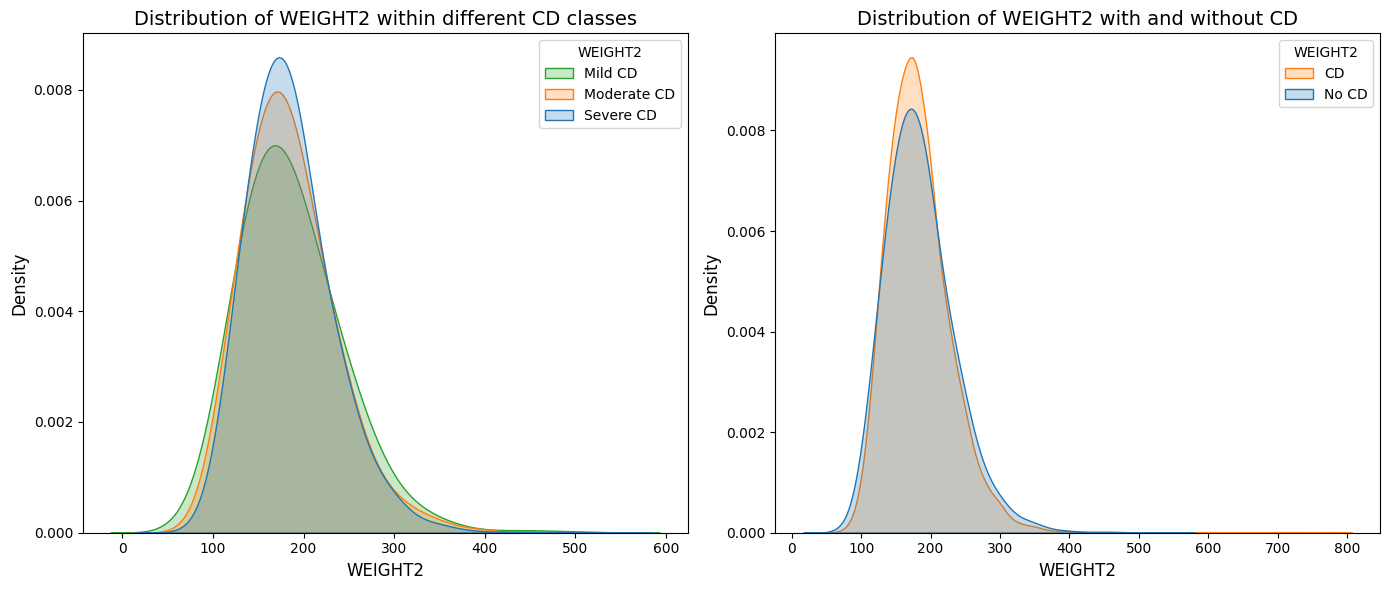

p-value for multi-class classification is: 0.5790500266850747
p-value for binary classification: 6.552561275418824e-05


In [21]:
feature = 'WEIGHT2';

explore_cts(df, feature, none=8888, not_sure=7777, refused=9999)

In [22]:
df['HEIGHT3'].unique()

array([ 511.,  502.,  506.,  510.,  504.,  503.,  507.,  505.,  406.,
        500.,  604.,  600.,  509.,  411.,  603.,  508., 7777.,  601.,
        501., 9999.,  602.,  409.,  605.,  410.,  606.,  405.,  407.,
        408.,  401., 9144.,  400.,  306.,  607.,  608.,  609., 9172.,
       9156., 9175., 9150.,  300., 9165.,  611.,  610., 9174., 9155.,
       9152., 9178., 9166., 9170., 9107., 9105., 9158., 9164., 9157.,
       9140.,  703.,  800., 9205., 9171., 9103., 9160.,  700.,  705.,
        708., 9161., 9145., 9176., 9162.,  701., 9177.,  801.,  402.,
        702.,  404., 9163., 9173., 9180., 9168., 9153., 9169., 9147.,
       9151.,  302., 9159., 9154., 9106.,  706., 9130., 9185., 9167.,
        403., 9104., 9182.,  305., 9148., 9179.])

In [23]:
# HEIGHT3: it is contimuous

def process_height(kg):
  kg=int(kg)
  if len(str(kg)) == 4:
    if 9061 <= kg <= 9998:
        kg_without_nine = int(str(kg)[1:])  # 去掉首位的'9'
        pounds = round(kg_without_nine * 39.3701/100)  # 转换千克到磅
        return pounds
  return kg  # 不在范围内的保持不变

# 应用这个函数到DataFrame的Weight列
df['HEIGHT3']= df['HEIGHT3'].apply(process_height)


In [24]:
df['HEIGHT3'] = df['HEIGHT3'].fillna(8888)

In [25]:
df['HEIGHT3'].unique()

array([ 511,  502,  506,  510,  504,  503,  507,  505,  406,  500,  604,
        600,  509,  411,  603,  508, 7777,  601,  501, 9999,  602,  409,
        605,  410,  606,  405,  407,  408,  401,   57,  400,  306,  607,
        608,  609,   68,   61,   69,   59,  300,   65,  611,  610,   60,
         70,   67,   42,   41,   62,   55,  703,  800,   81,   63,  700,
        705,  708,   64,  701,  801,  402,  702,  404,   71,   66,   58,
        302,  706,   51,   73,  403,   72,  305])

There are 0 missing values, 420 not sure values, 923 refused values


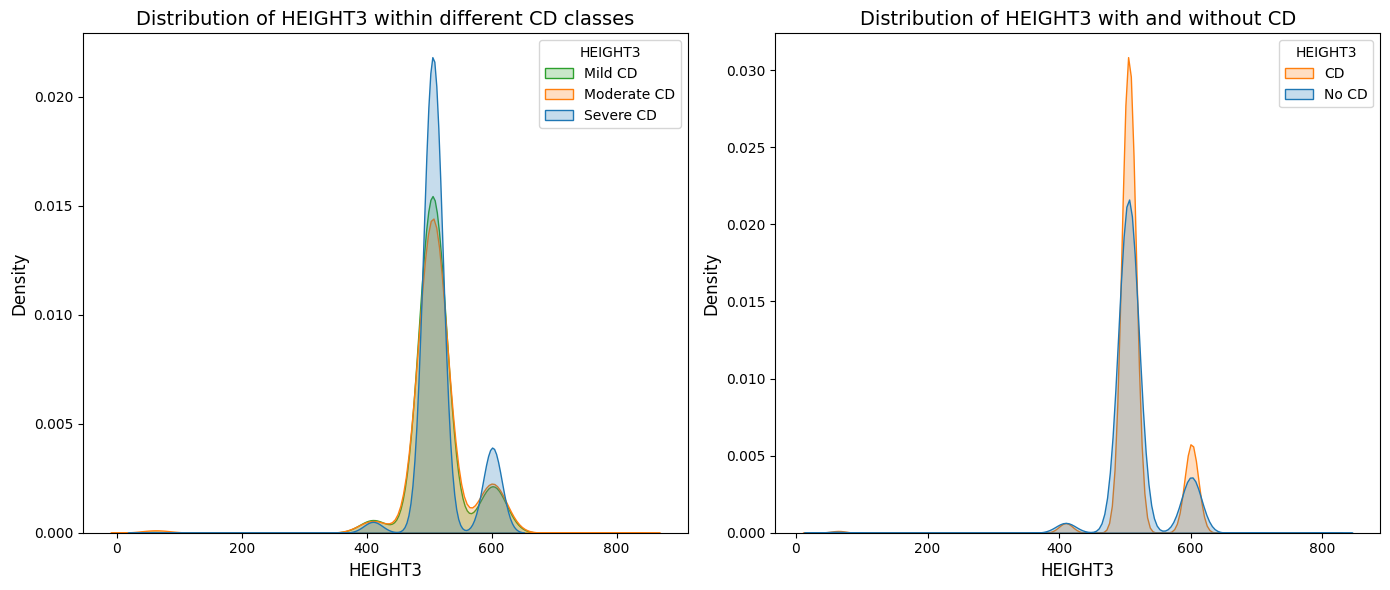

p-value for multi-class classification is: 3.7097725442993427e-06
p-value for binary classification: 0.002993224559692686


In [26]:
feature = 'HEIGHT3';

explore_cts(df, feature, none=8888, not_sure=7777, refused=9999)

There are 0 missing values, 235 not sure, 51 refused


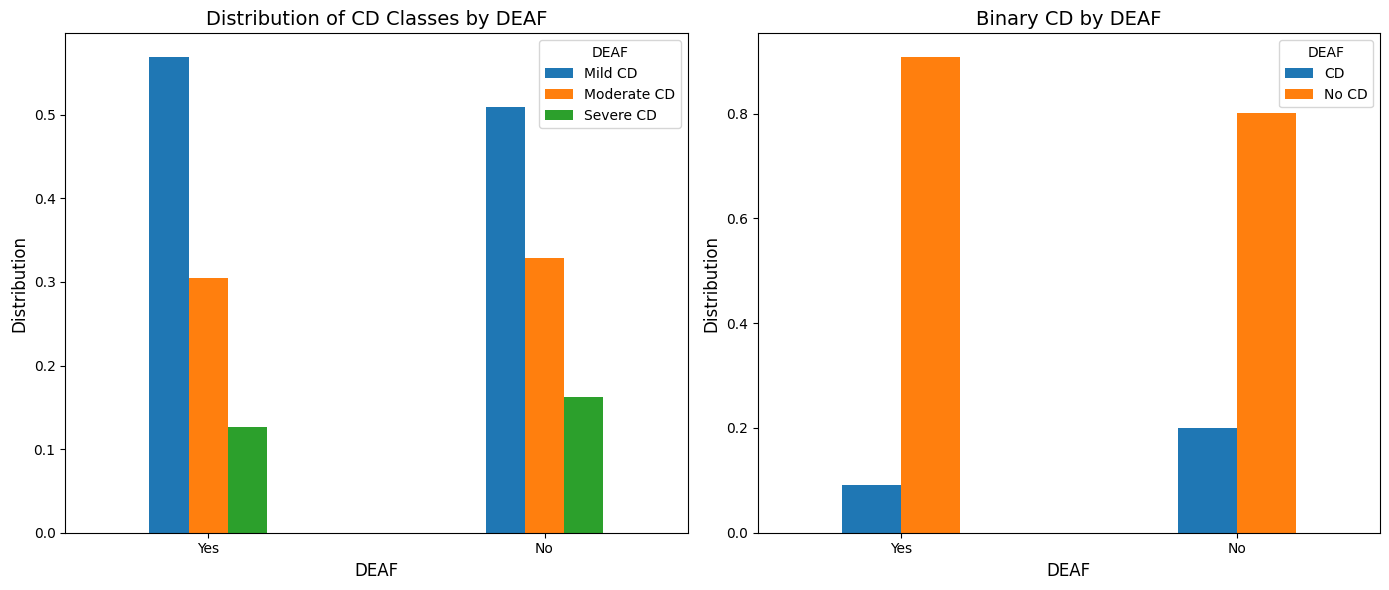

Cramers V for multi-class classification is: 0.05269056112422206
Cramers V for binary classification is: 0.11326941773848878


In [27]:
#'DEAF'
explore_binary(df, 'DEAF', include_refused=False)

There are 0 missing values, 195 not sure, 48 refused


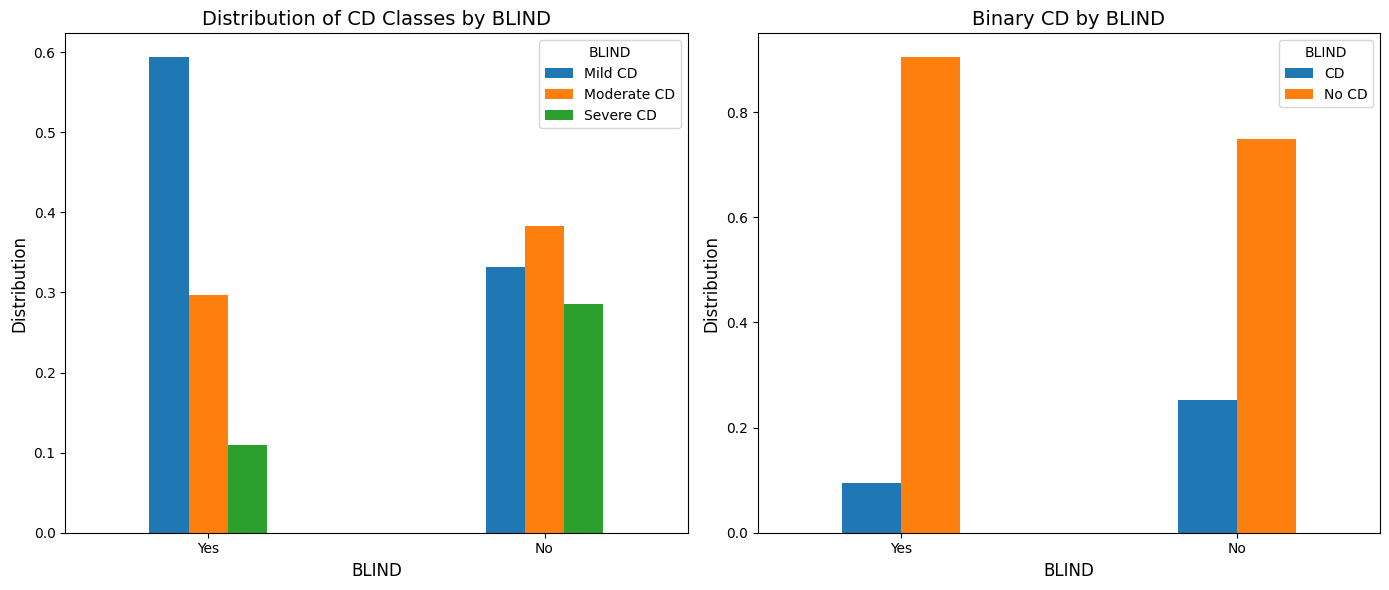

Cramers V for multi-class classification is: 0.21471115484556602
Cramers V for binary classification is: 0.12060149555887749


In [28]:
# 'BLIND' binary

explore_binary(df, 'BLIND', include_refused=False)

There are 0 missing values, 322 not sure, 70 refused


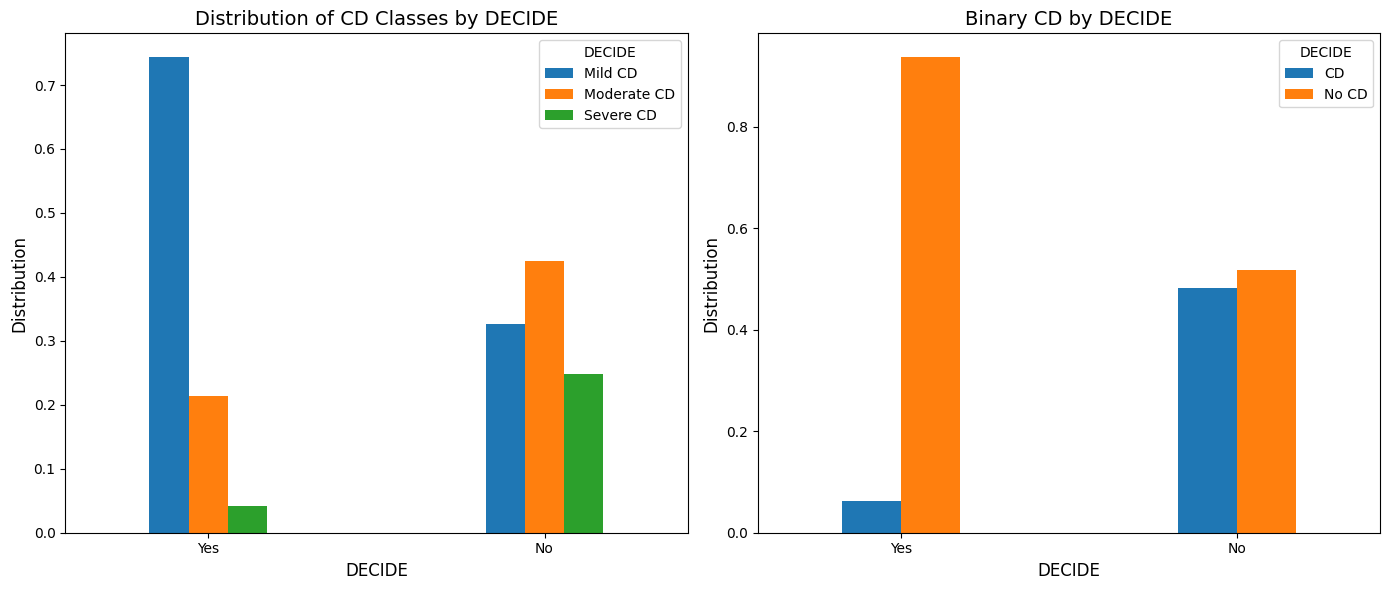

Cramers V for multi-class classification is: 0.43636442637918843
Cramers V for binary classification is: 0.4076296382456461


In [29]:

#'DECIDE' binary

explore_binary(df, 'DECIDE', include_refused=False)

There are 0 missing values, 237 not sure, 31 refused


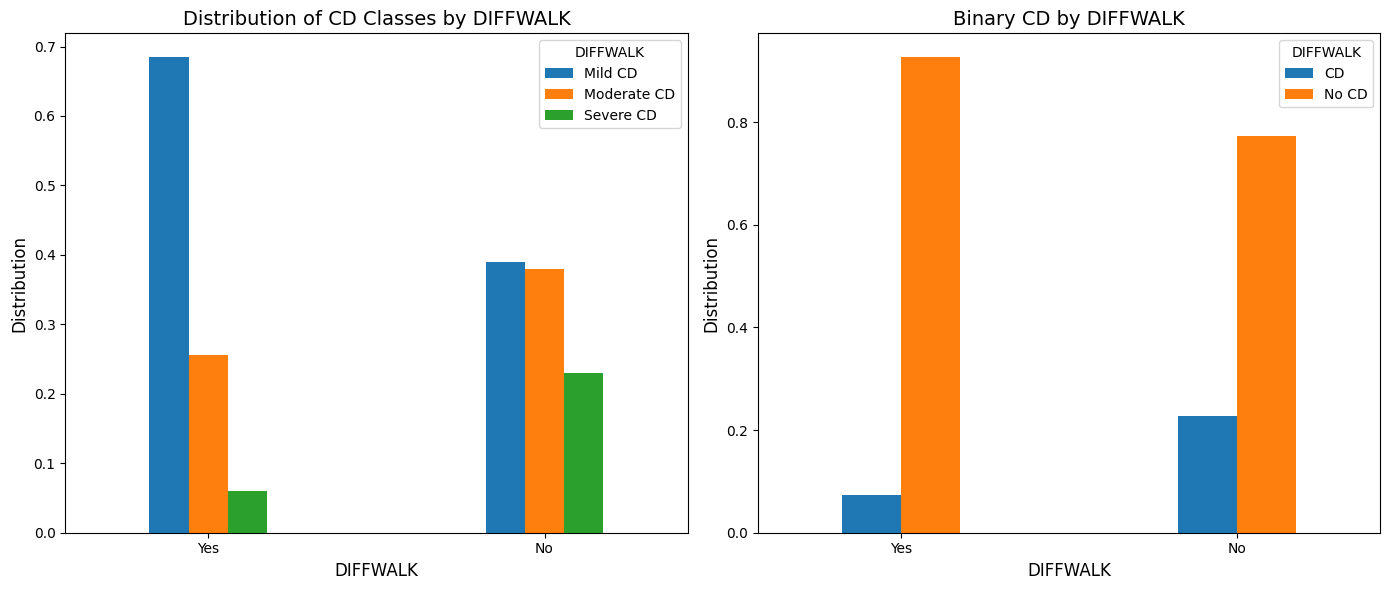

Cramers V for multi-class classification is: 0.32106164946613397
Cramers V for binary classification is: 0.20149154941759415


In [30]:

# 'DIFFWALK'-binary

explore_binary(df, 'DIFFWALK', include_refused=False)

There are 0 missing values, 71 not sure, 21 refused


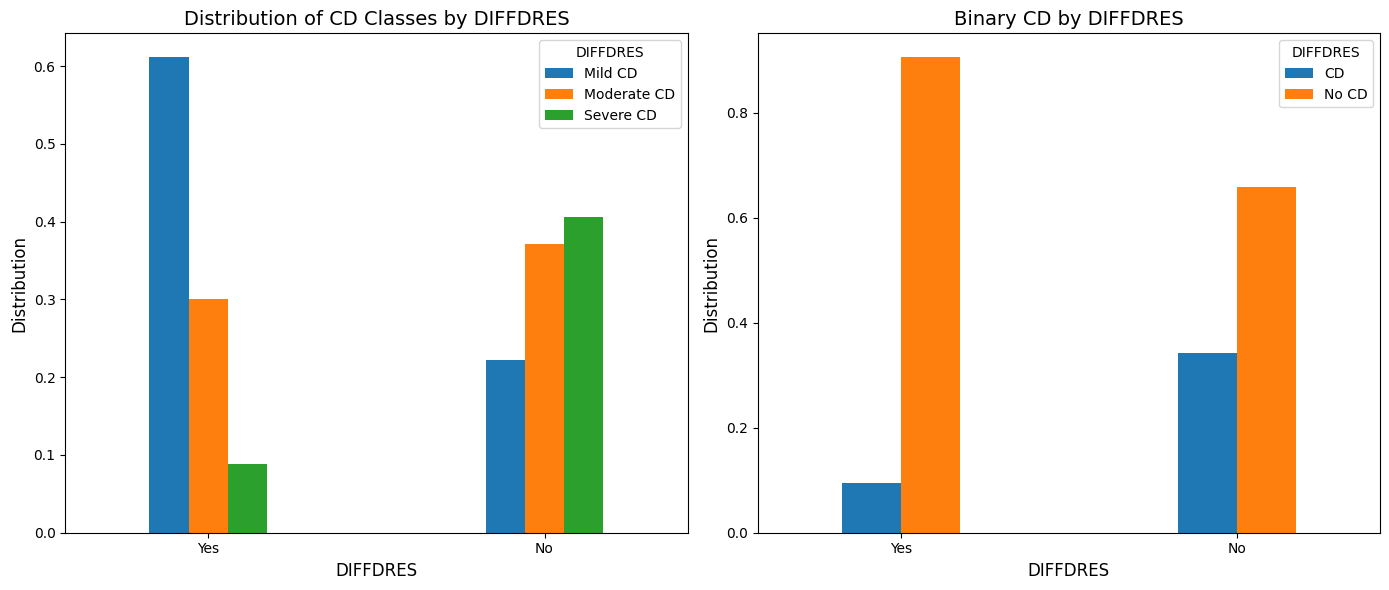

Cramers V for multi-class classification is: 0.35764130817670553
Cramers V for binary classification is: 0.16558544949858434


In [31]:
#'DIFFDRES'-binary
explore_binary(df, 'DIFFDRES', include_refused=False)

There are 0 missing values, 146 not sure, 39 refused


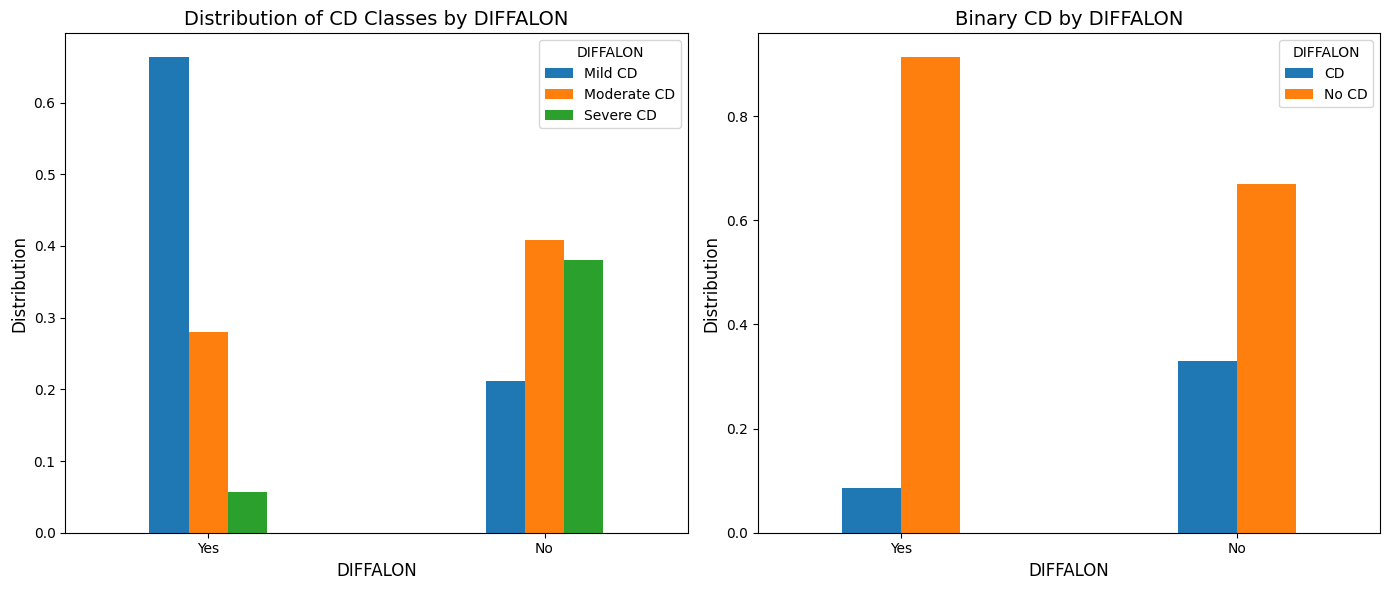

Cramers V for multi-class classification is: 0.46575154447043593
Cramers V for binary classification is: 0.2100782773093238


In [32]:

# 'DIFFALON'-binary
explore_binary(df, 'DIFFALON', include_refused=False)

There are 28399 missing values, 47 not sure, 57 refused


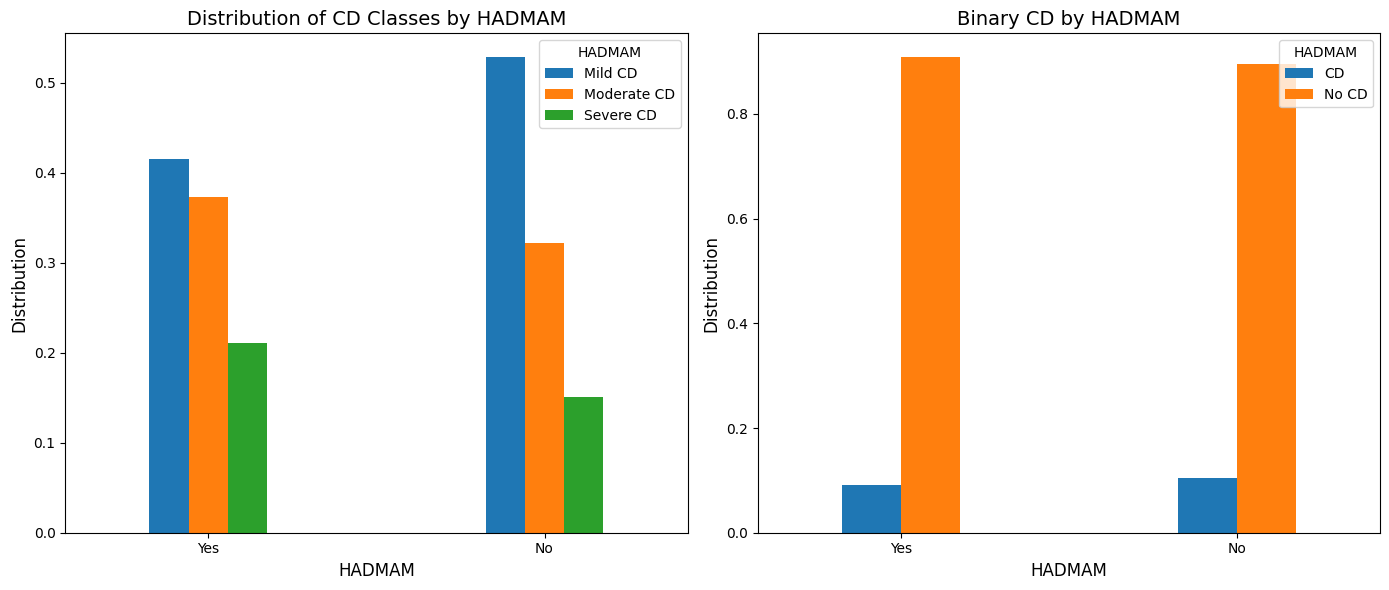

Cramers V for multi-class classification is: 0.039632730486910635
Cramers V for binary classification is: 0.007003761555929813


In [33]:

#'HADMAM'-binary
explore_binary(df, 'HADMAM', include_refused=False)


There are 30055 missing values, 570 not sure values, 52 refused values


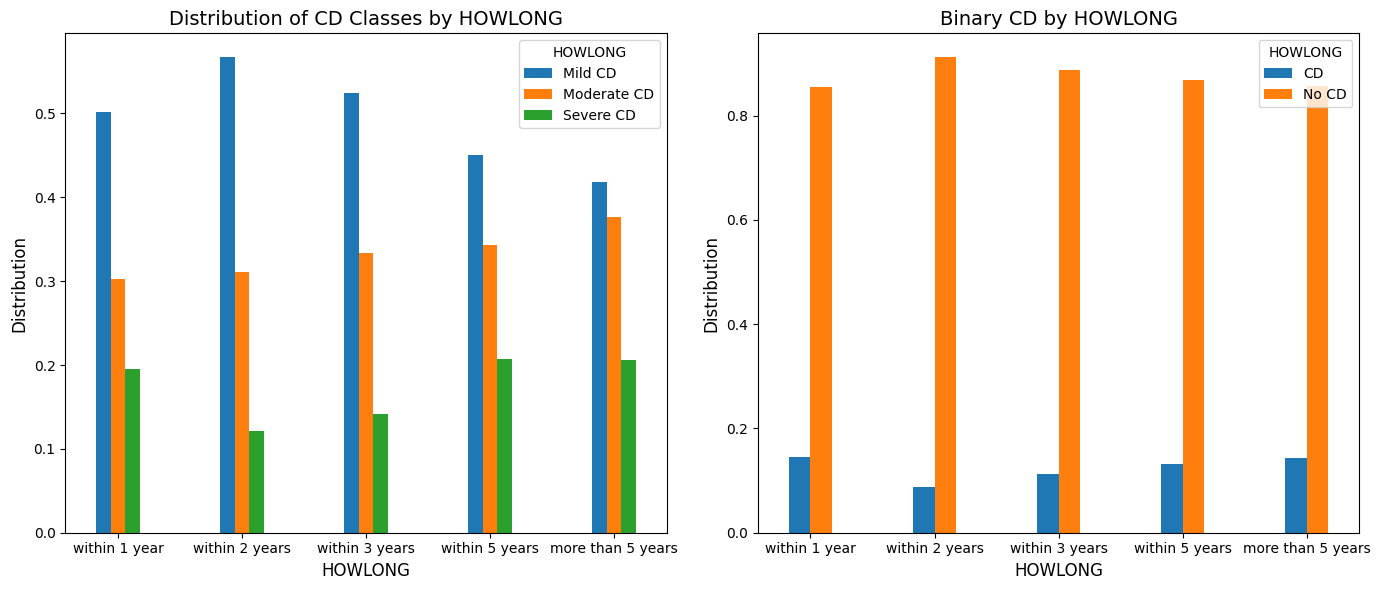

Cramers V for multi-class classification is: 0.07561719013507624
Cramers V for binary classification is: 0.07187227962937098


In [34]:

#'HOWLONG'- cat

mapping = {1: 'within 1 year', 2: 'within 2 years', 3: 'within 3 years', 4: 'within 5 years', 5: 'more than 5 years',
            7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'HOWLONG'

explore_cat(df, feature, mapping, include_refused=False)

There are 28399 missing values, 2690 not sure, 93 refused


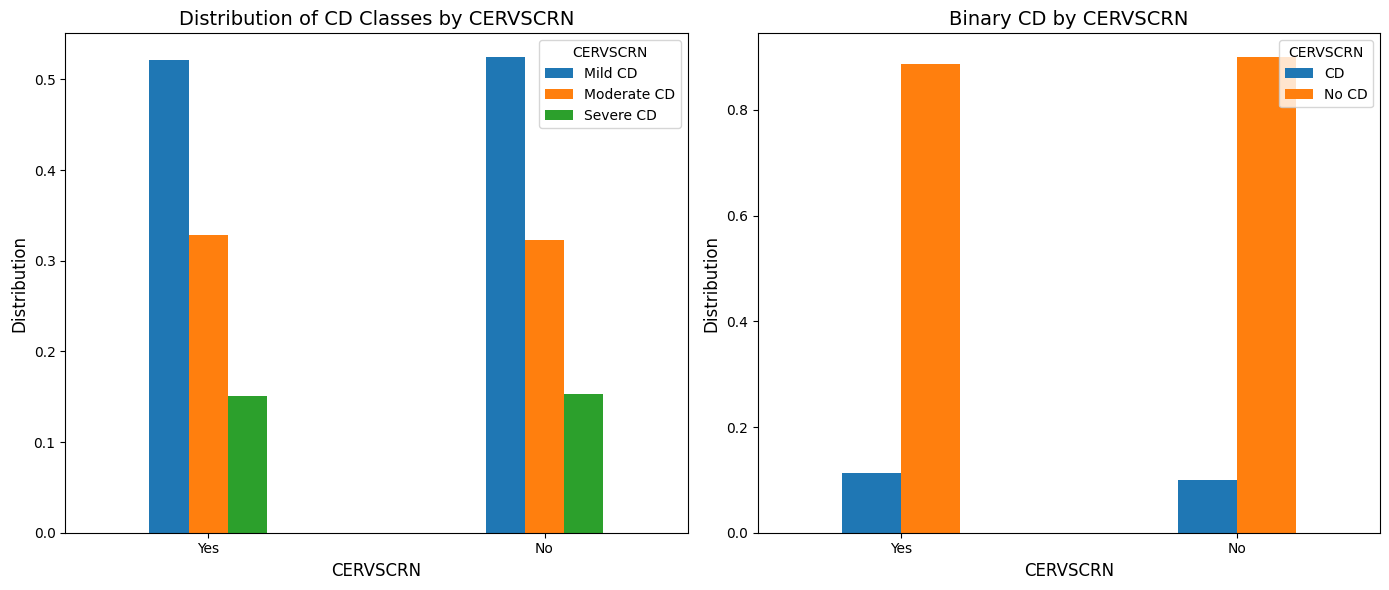

Cramers V for multi-class classification is: 0.0
Cramers V for binary classification is: 0.018362541679153282


In [35]:

# 'CERVSCRN' binary

explore_binary(df, 'CERVSCRN', include_refused=False)

There are 40550 missing values, 1234 not sure, 70 refused


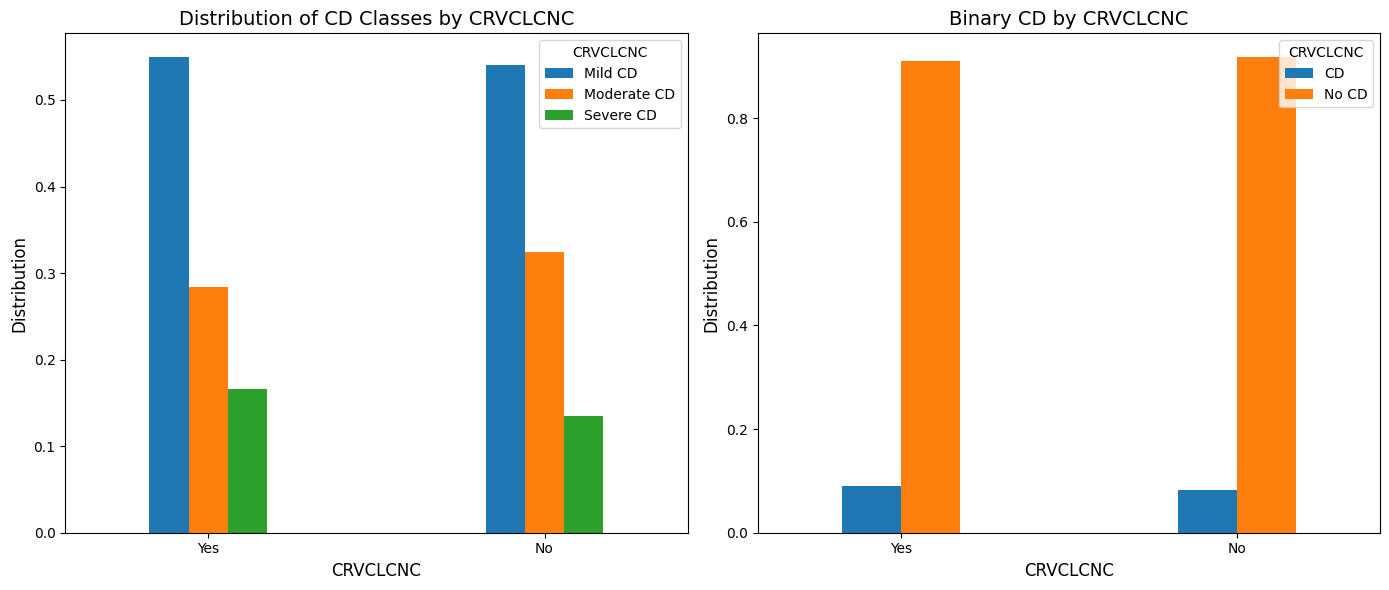

Cramers V for multi-class classification is: 0.01693685857689748
Cramers V for binary classification is: 0.006533741762576544


In [36]:

#   'CRVCLCNC'-binary
explore_binary(df, 'CRVCLCNC', include_refused=False)

There are 40550 missing values, 657 not sure, 42 refused


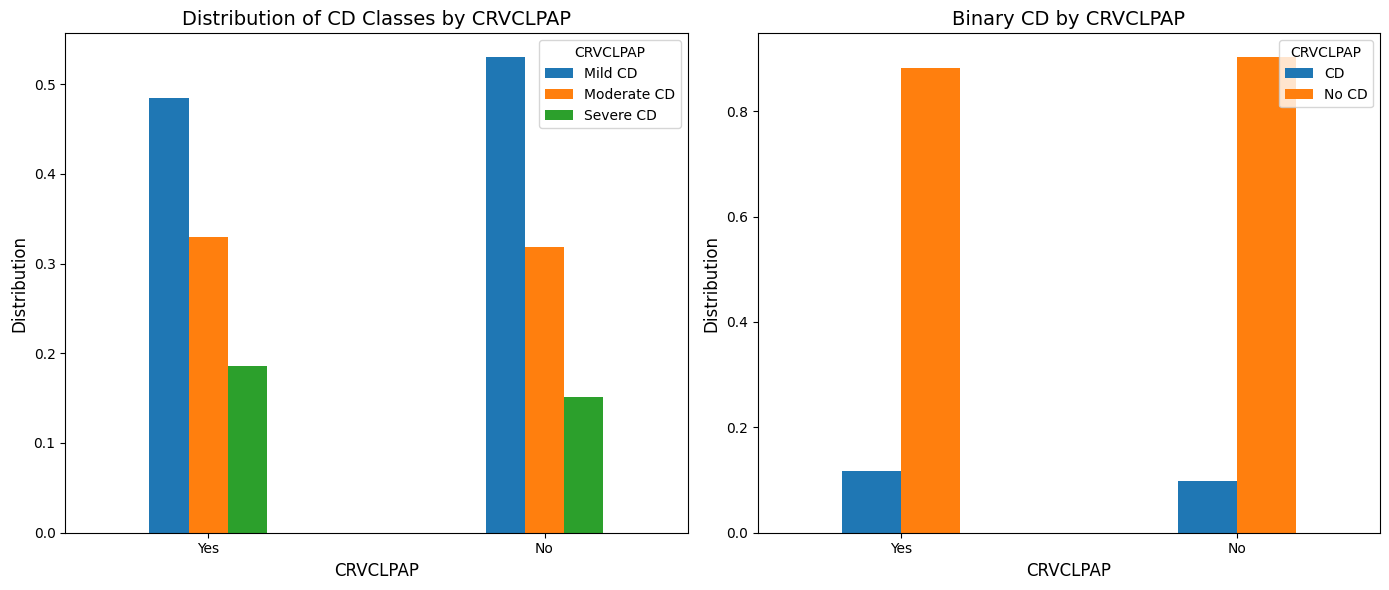

Cramers V for multi-class classification is: 0.006035067502459481
Cramers V for binary classification is: 0.01628086581042027


In [37]:

#'CRVCLPAP'-binary
explore_binary(df, 'CRVCLPAP', include_refused=False)

There are 40550 missing values, 8006 not sure, 49 refused


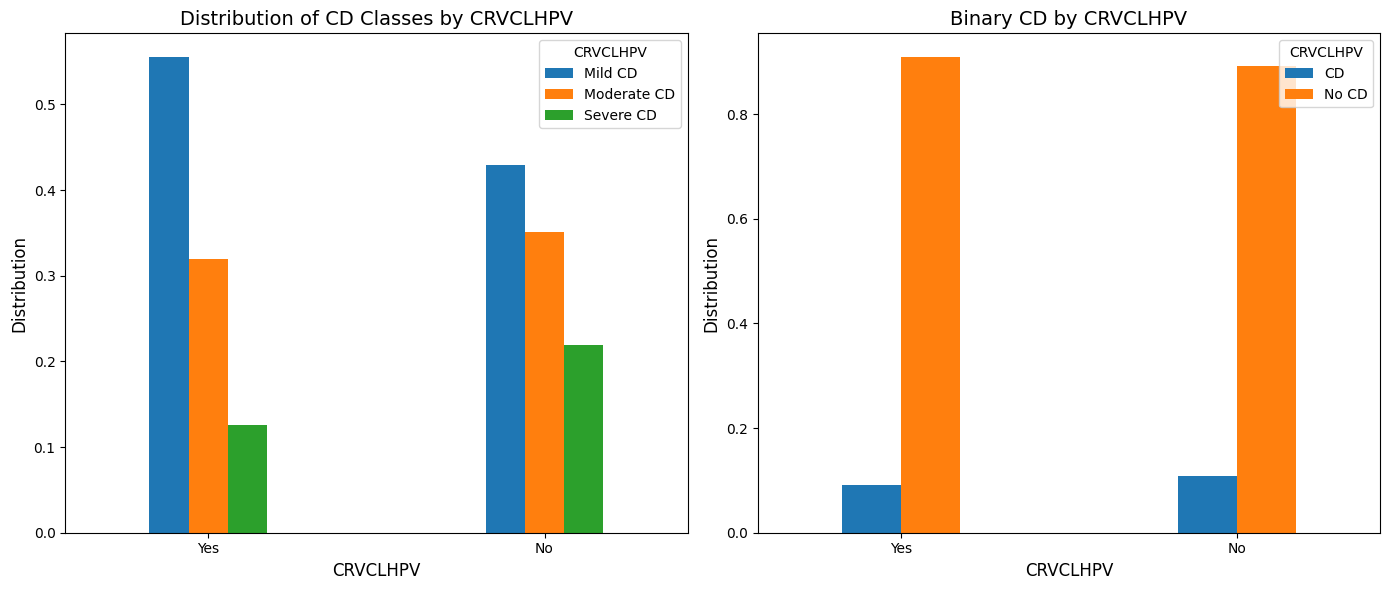

Cramers V for multi-class classification is: 0.14168979047215594
Cramers V for binary classification is: 0.02769618490678845


In [38]:
#'CRVCLHPV'-binary
explore_binary(df, 'CRVCLHPV', include_refused=False)

There are 28417 missing values, 65 not sure, 96 refused


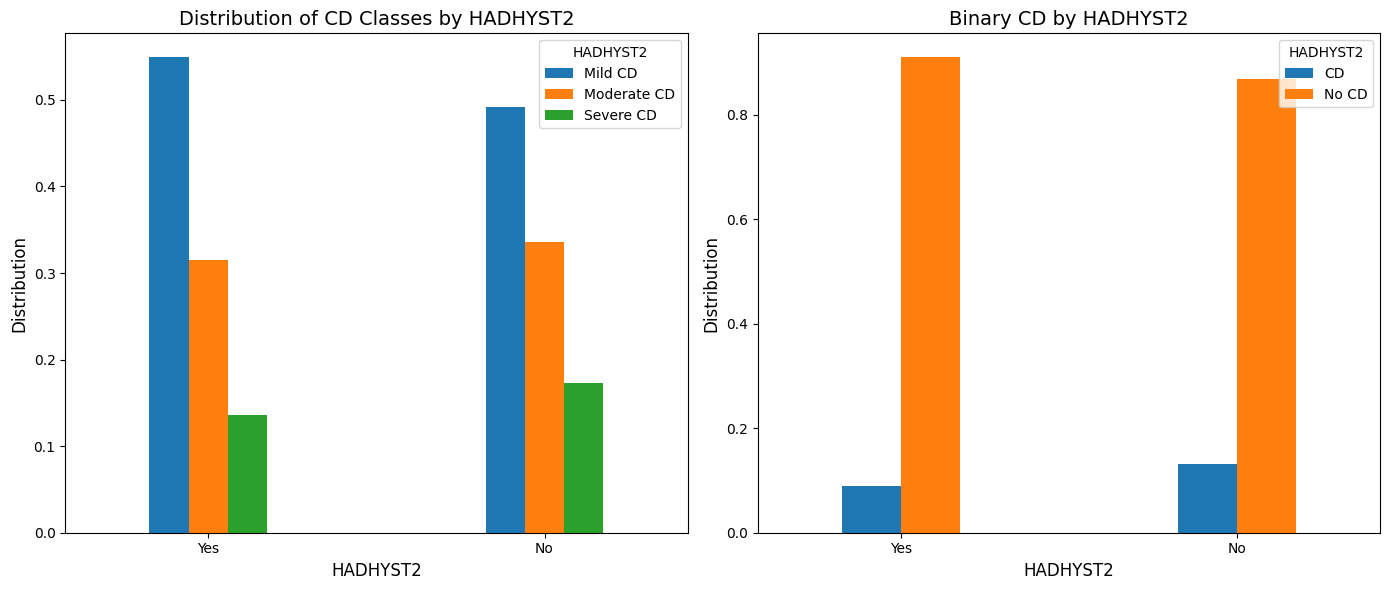

Cramers V for multi-class classification is: 0.059891242431292985
Cramers V for binary classification is: 0.06437932148006595


In [39]:

#'HADHYST2'-binary
explore_binary(df, 'HADHYST2', include_refused=False)

There are 1 missing values, 363 not sure, 108 refused


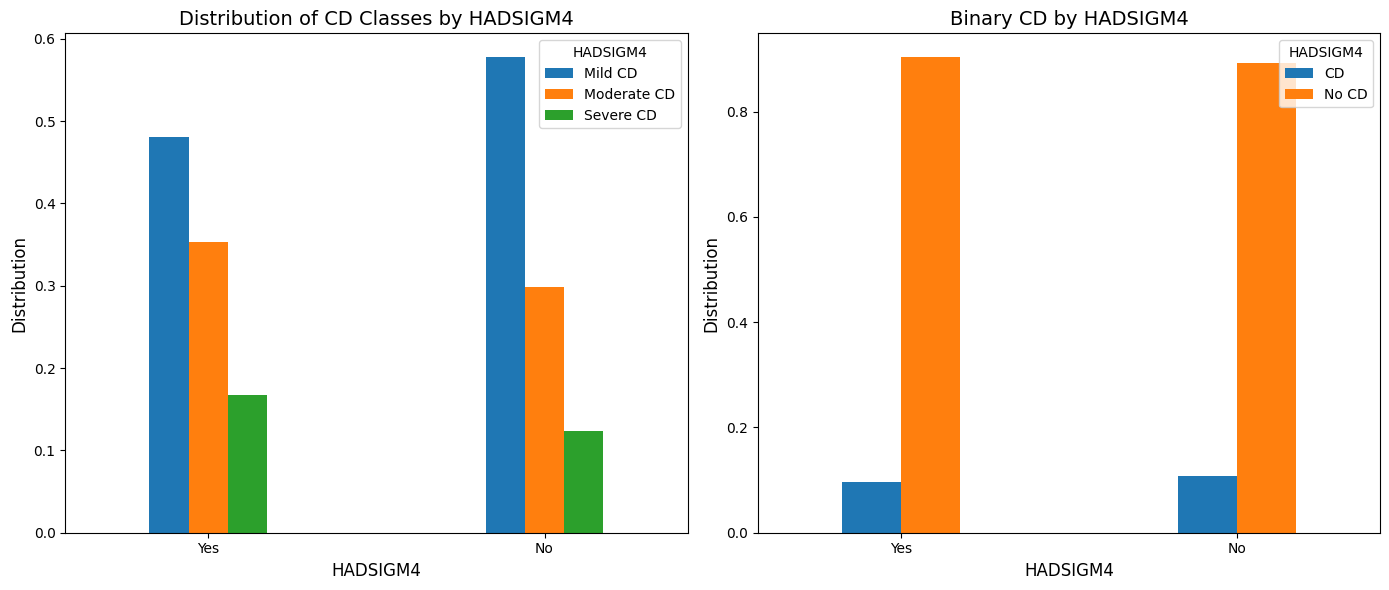

Cramers V for multi-class classification is: 0.08082798215260269
Cramers V for binary classification is: 0.014814195629374959


In [40]:

#'HADSIGM4'-binary
explore_binary(df, 'HADSIGM4', include_refused=False)

There are 15301 missing values, 698 not sure values, 65 refused values


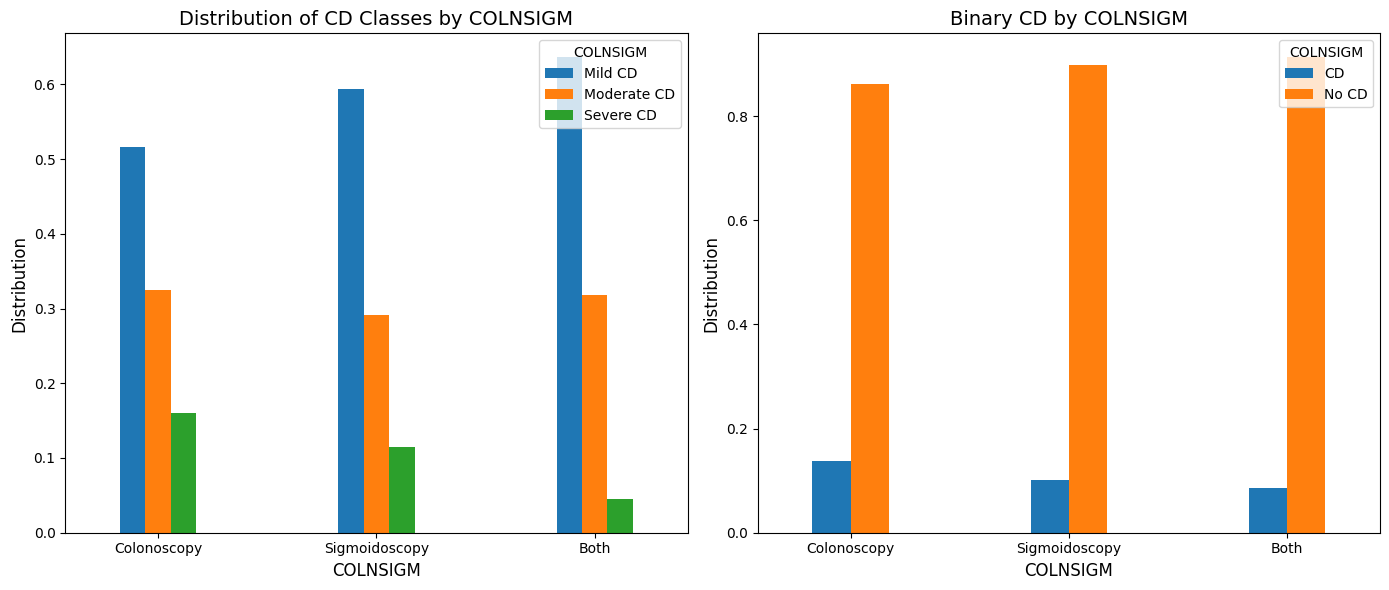

Cramers V for multi-class classification is: 0.045673104358563414
Cramers V for binary classification is: 0.04150702707999056


In [41]:

#  'COLNSIGM'-cat
mapping = {1: 'Colonoscopy', 2: 'Sigmoidoscopy', 3: 'Both', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'COLNSIGM'

explore_cat(df, feature, mapping, include_refused=False)

There are 16318 missing values, 930 not sure values, 43 refused values


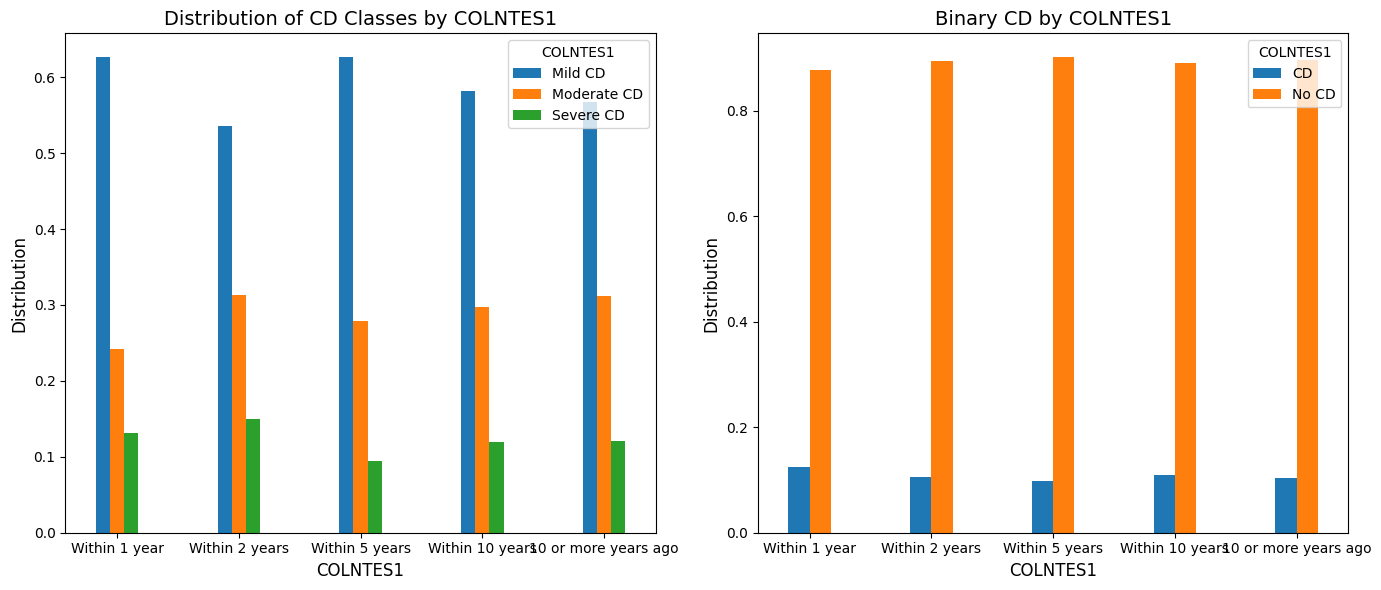

Cramers V for multi-class classification is: 0.04750321837069004
Cramers V for binary classification is: 0.019604748419357505


In [42]:
#'COLNTES1'-cat
mapping = {1: 'Within 1 year', 2: 'Within 2 years', 3: 'Within 5 years',4: 'Within 10 years', 5:'10 or more years ago', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'COLNTES1'

explore_cat(df, feature, mapping, include_refused=False)

There are 56349 missing values, 855 not sure values, 68 refused values


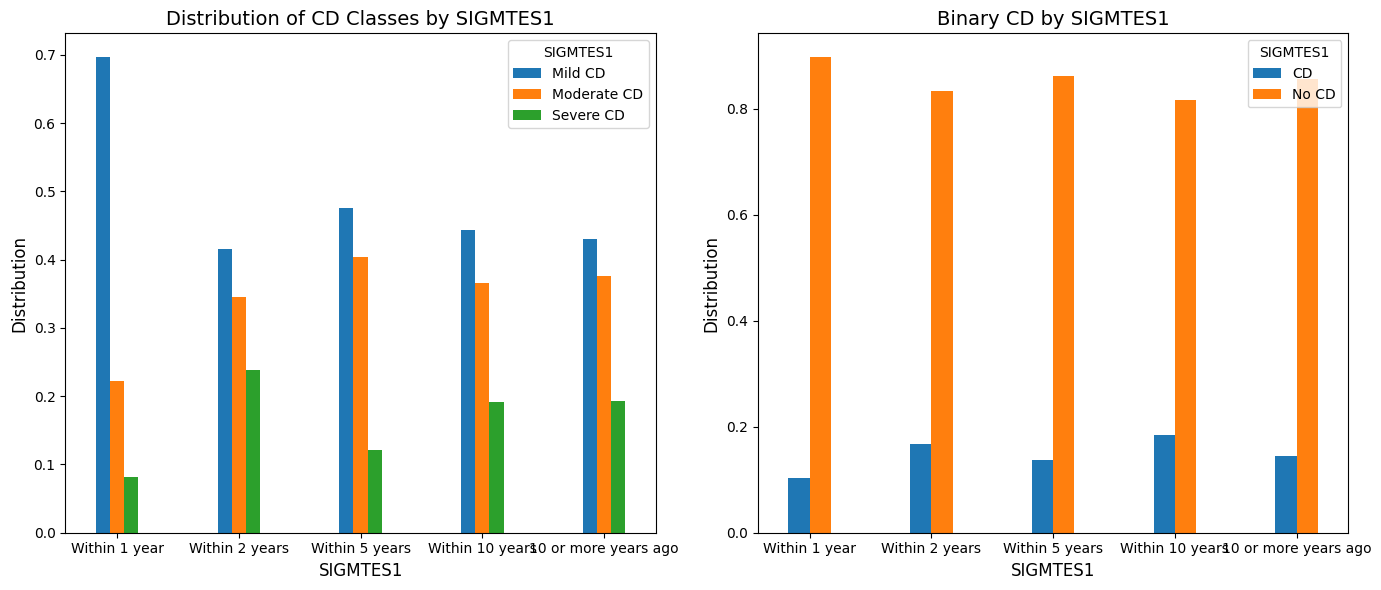

Cramers V for multi-class classification is: 0.16833305381095873
Cramers V for binary classification is: 0.08194084159490024


In [43]:
#'SIGMTES1'-cat
mapping = {1: 'Within 1 year', 2: 'Within 2 years', 3: 'Within 5 years',4: 'Within 10 years', 5:'10 or more years ago', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'SIGMTES1'

explore_cat(df, feature, mapping, include_refused=False)

In [44]:
df['LASTSIG4'].unique()

array([nan,  3.,  7.,  1.,  4.,  5.,  2.,  9.])

There are 62932 missing values, 126 not sure values, 3 refused values


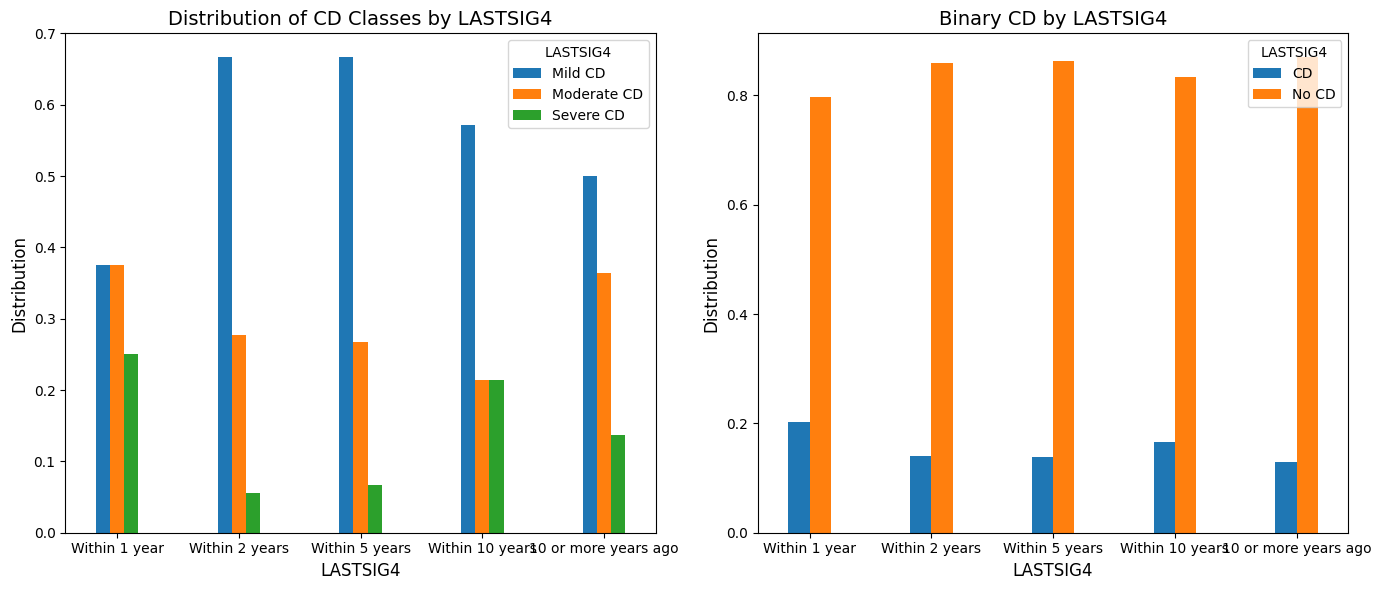

Cramers V for multi-class classification is: 0.0
Cramers V for binary classification is: 0.0


In [45]:
# 'LASTSIG4',
mapping = {1: 'Within 1 year', 2: 'Within 2 years', 3: 'Within 5 years',4: 'Within 10 years', 5:'10 or more years ago', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'LASTSIG4'

explore_cat(df, feature, mapping, include_refused=False)

There are 1 missing values, 1739 not sure, 121 refused


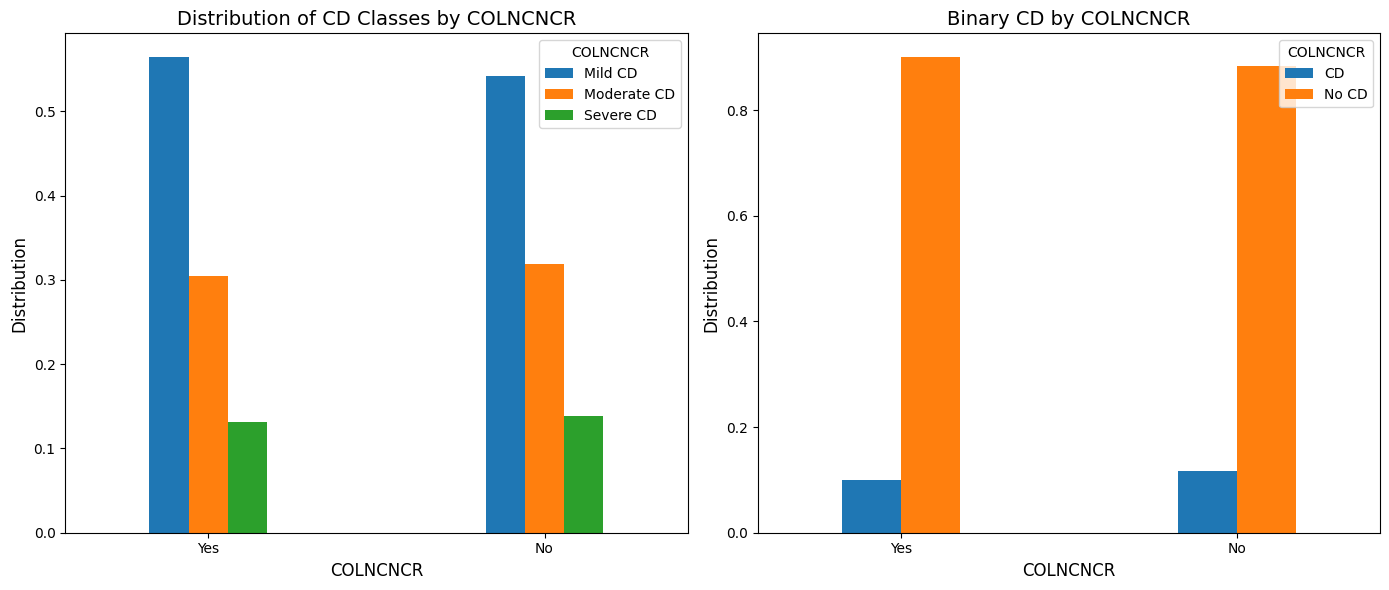

Cramers V for multi-class classification is: 0.006512261689201312
Cramers V for binary classification is: 0.022467279544741803


In [46]:

#'COLNCNCR'-binary
explore_binary(df, 'COLNCNCR', include_refused=False)


There are 50691 missing values, 591 not sure, 7 refused


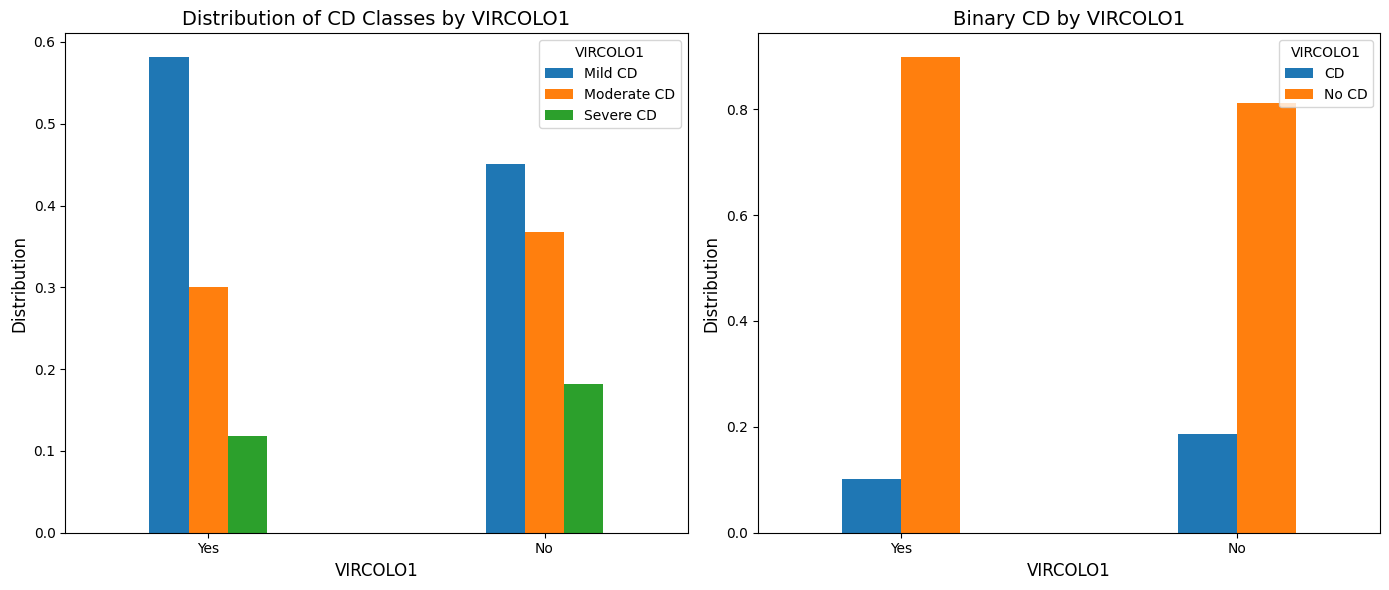

Cramers V for multi-class classification is: 0.1142160085413214
Cramers V for binary classification is: 0.09714037485787032


In [47]:
#'VIRCOLO1'-binary
explore_binary(df, 'VIRCOLO1', include_refused=False)

There are 61697 missing values, 102 not sure values, 3 refused values


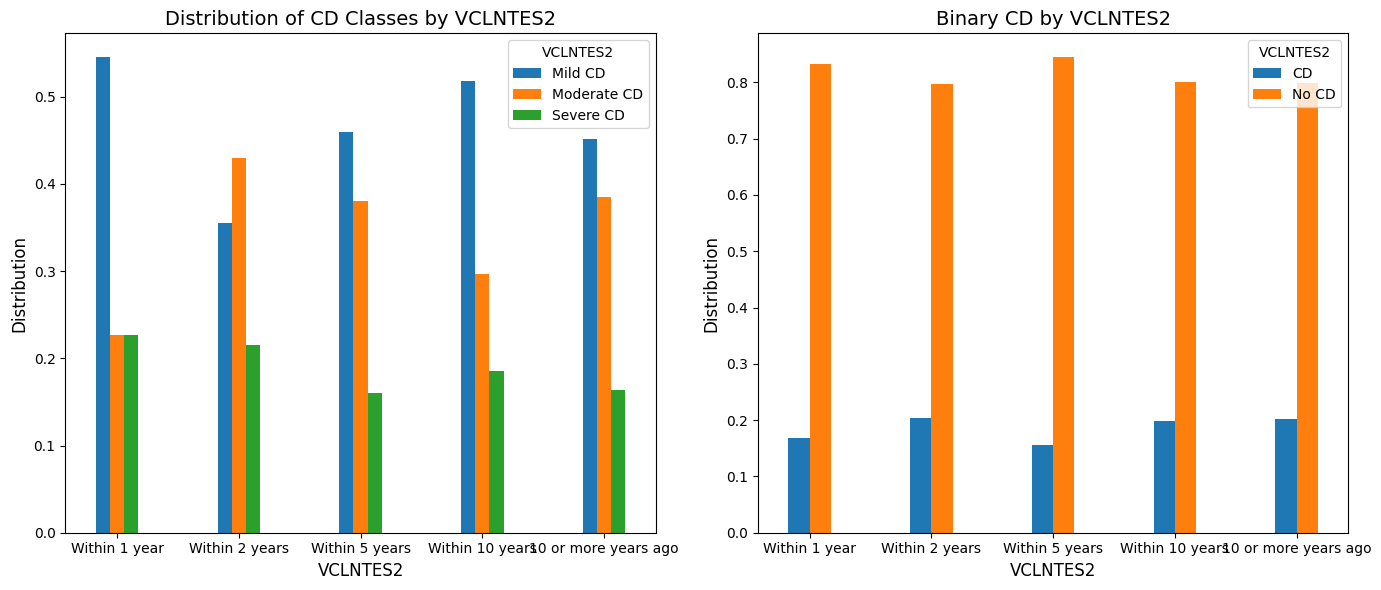

Cramers V for multi-class classification is: 0.03442915678750497
Cramers V for binary classification is: 0.016412490438278644


In [48]:
#'VCLNTES2'-cat
mapping = {1: 'Within 1 year', 2: 'Within 2 years', 3: 'Within 5 years',4: 'Within 10 years', 5:'10 or more years ago', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'VCLNTES2'
explore_cat(df, feature, mapping, include_refused=False)

There are 50691 missing values, 150 not sure, 9 refused


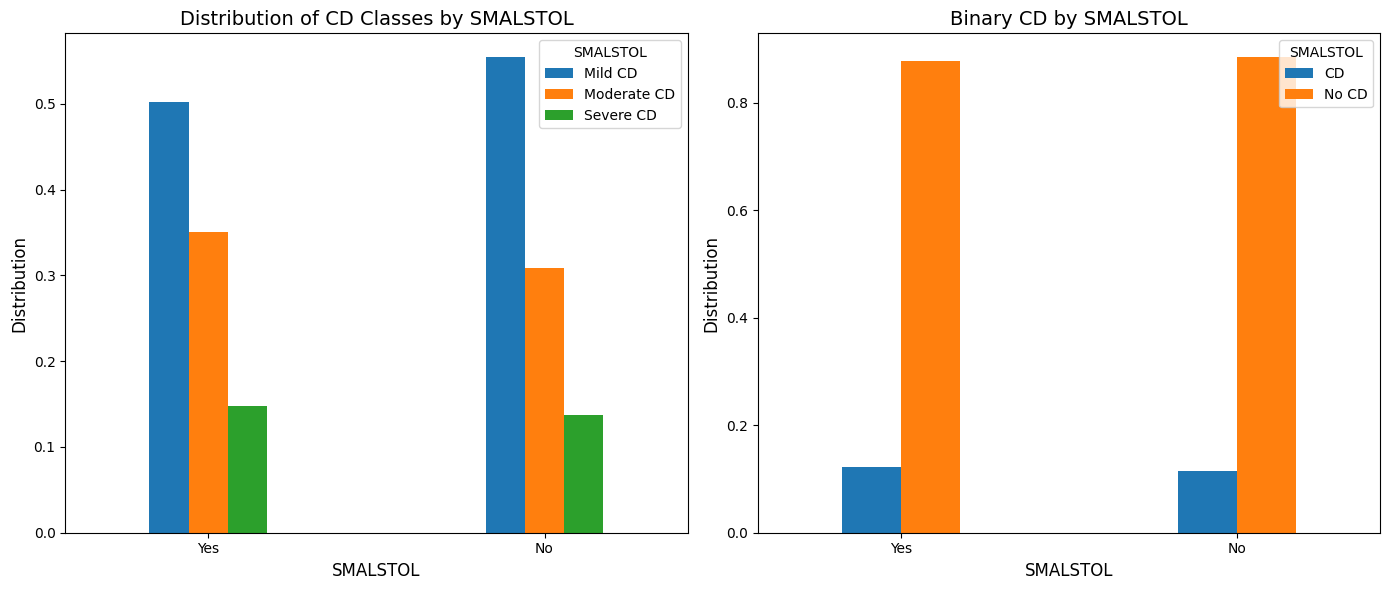

Cramers V for multi-class classification is: 0.02387584546988205
Cramers V for binary classification is: 0.002454989483096395


In [49]:
#'SMALSTOL'-binary
explore_binary(df, 'SMALSTOL', include_refused=False)

There are 53394 missing values, 307 not sure values, 13 refused values


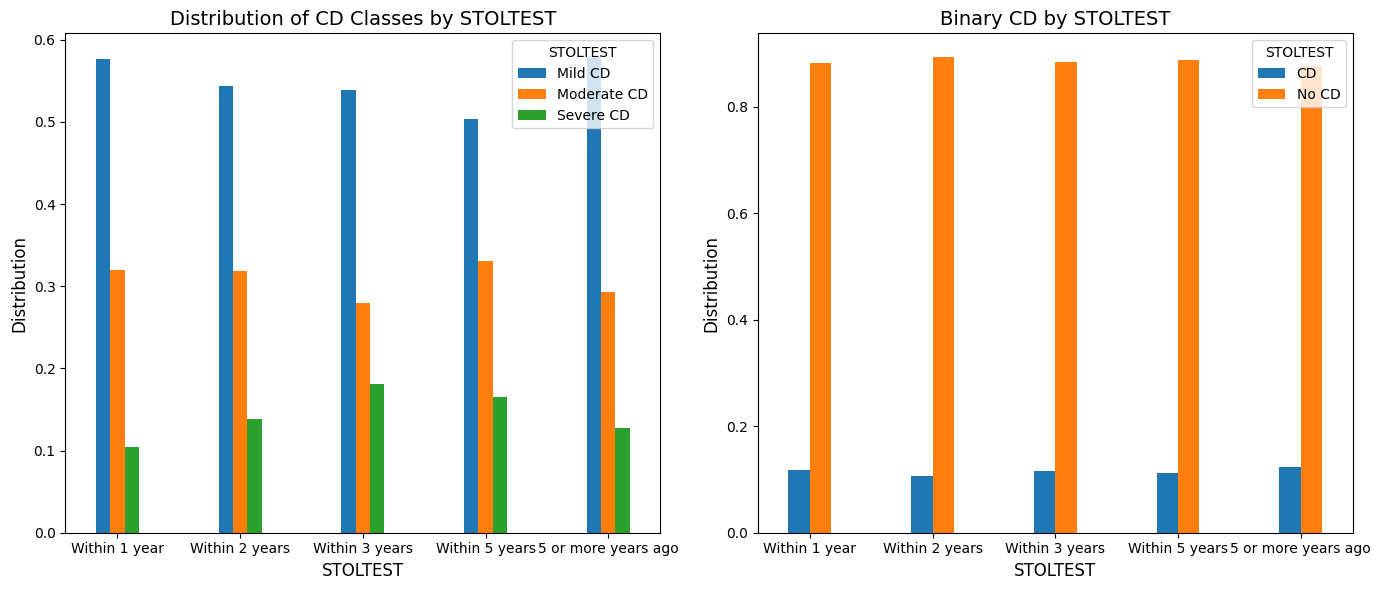

Cramers V for multi-class classification is: 0.0
Cramers V for binary classification is: 0.0


In [50]:
#'STOLTEST'-cat
mapping = {1: 'Within 1 year', 2: 'Within 2 years', 3: 'Within 3 years',4: 'Within 5 years', 5:'5 or more years ago', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'STOLTEST'
explore_cat(df, feature, mapping, include_refused=False)

There are 50691 missing values, 377 not sure, 15 refused


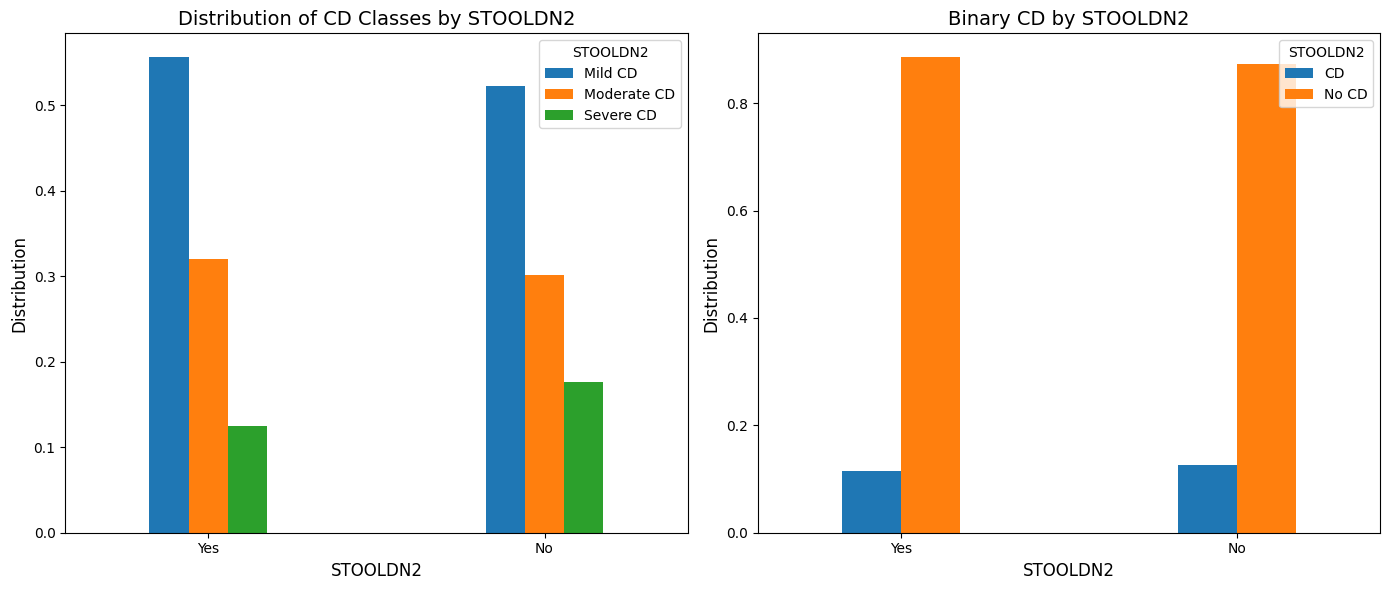

Cramers V for multi-class classification is: 0.050171430005718914
Cramers V for binary classification is: 0.012671064539599285


In [51]:
#'STOOLDN2'-binary
explore_binary(df, 'STOOLDN2', include_refused=False)

There are 61172 missing values, 327 not sure, 8 refused


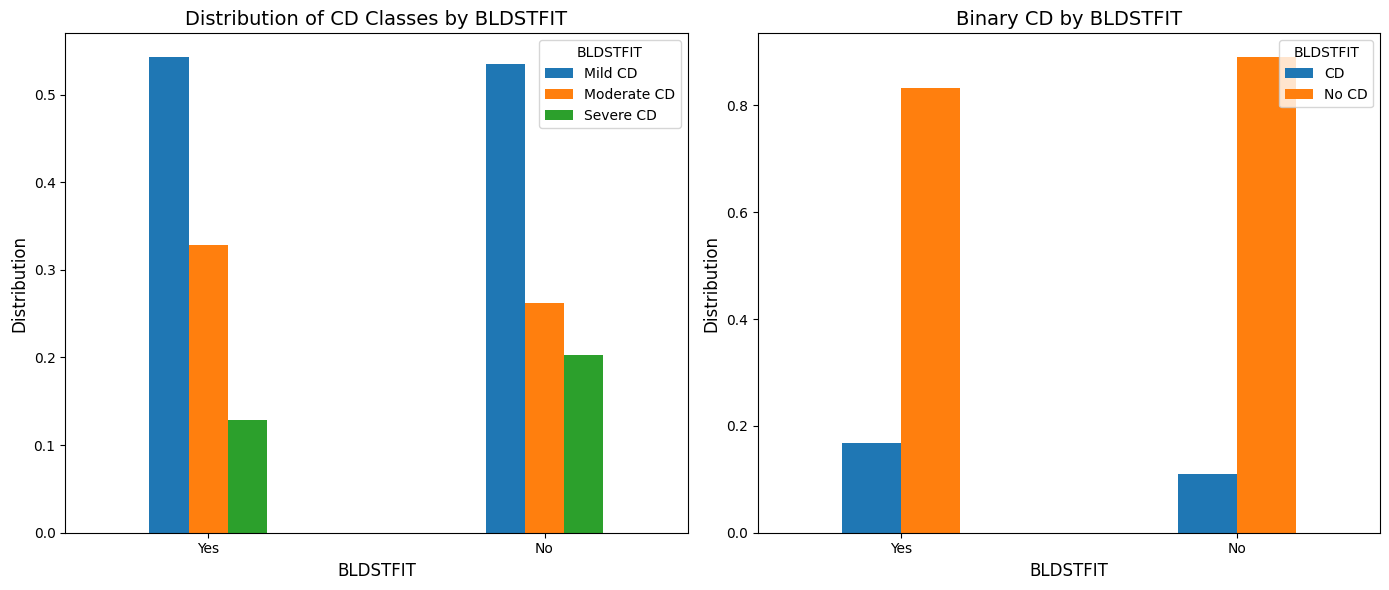

Cramers V for multi-class classification is: 0.03723099400849876
Cramers V for binary classification is: 0.06618087850419349


In [52]:
#'BLDSTFIT'-binary
explore_binary(df, 'BLDSTFIT', include_refused=False)


There are 61172 missing values, 113 not sure values, 8 refused values


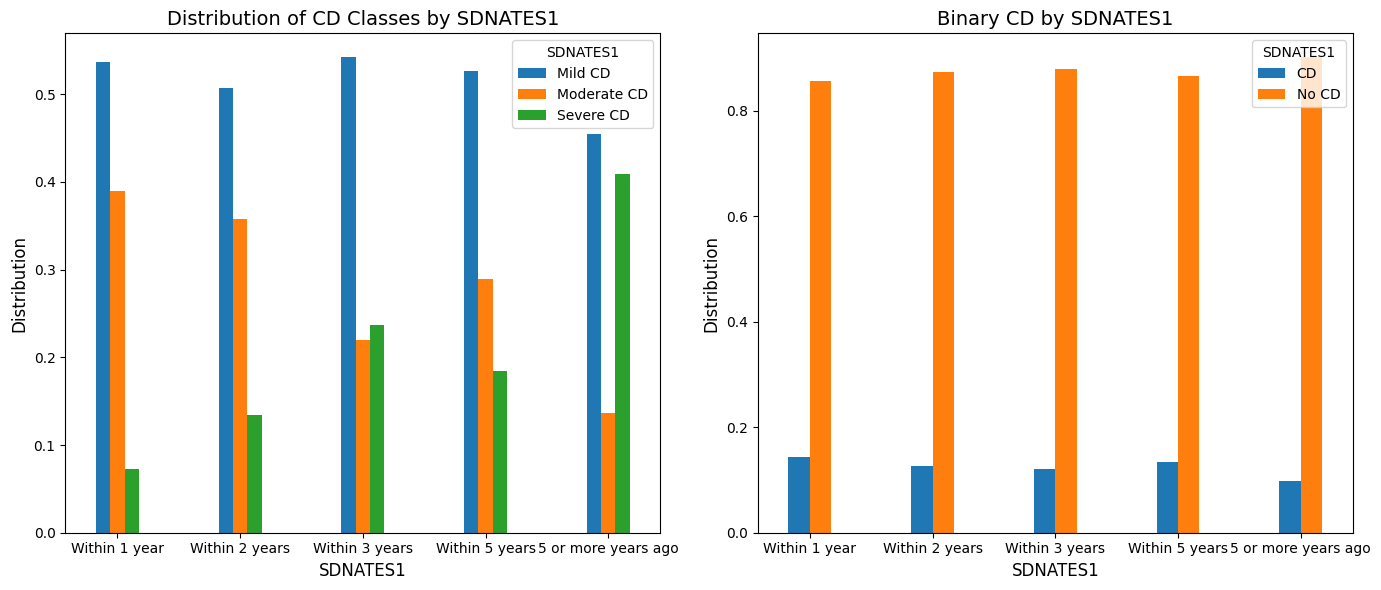

Cramers V for multi-class classification is: 0.13001062036053618
Cramers V for binary classification is: 0.0


In [53]:
#'SDNATES1'-cat
mapping = {1: 'Within 1 year', 2: 'Within 2 years', 3: 'Within 3 years',4: 'Within 5 years', 5:'5 or more years ago', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'SDNATES1'
explore_cat(df, feature, mapping, include_refused=False)

There are 0 missing values, 403 not sure, 59 refused


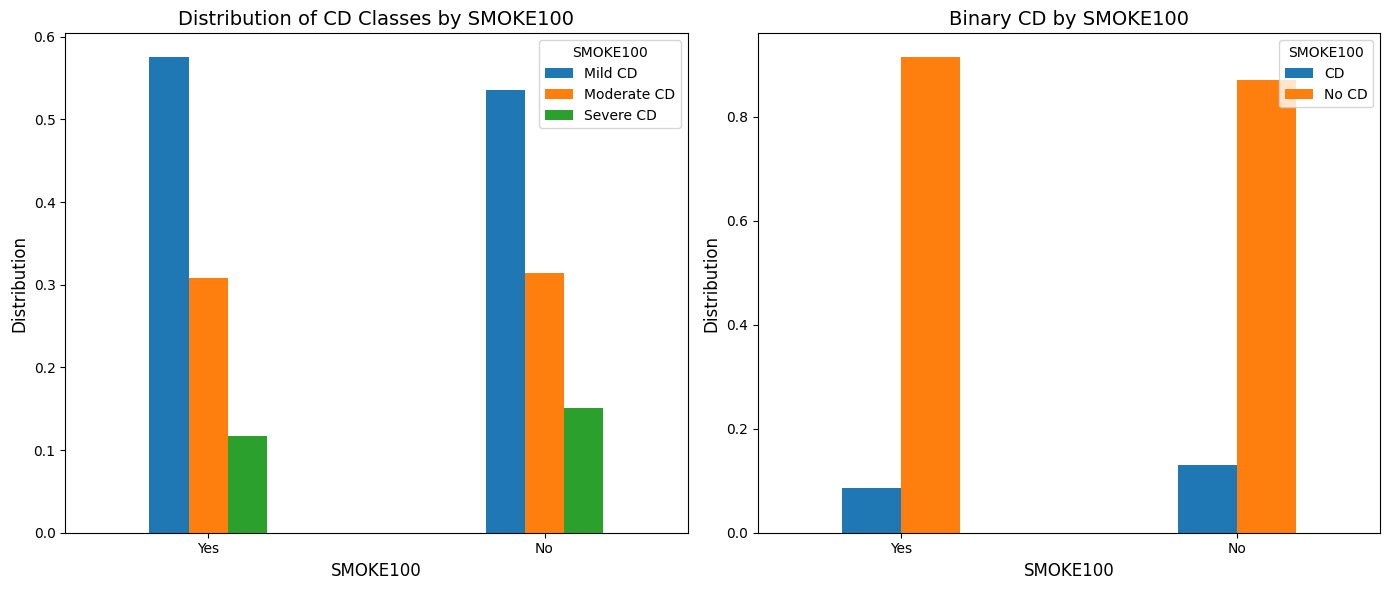

Cramers V for multi-class classification is: 0.05085006424047887
Cramers V for binary classification is: 0.07188298140031944


In [54]:
#'SMOKE100'-binary
explore_binary(df, 'SMOKE100', include_refused=False)

There are 35854 missing values, 37 not sure values, 37 refused values


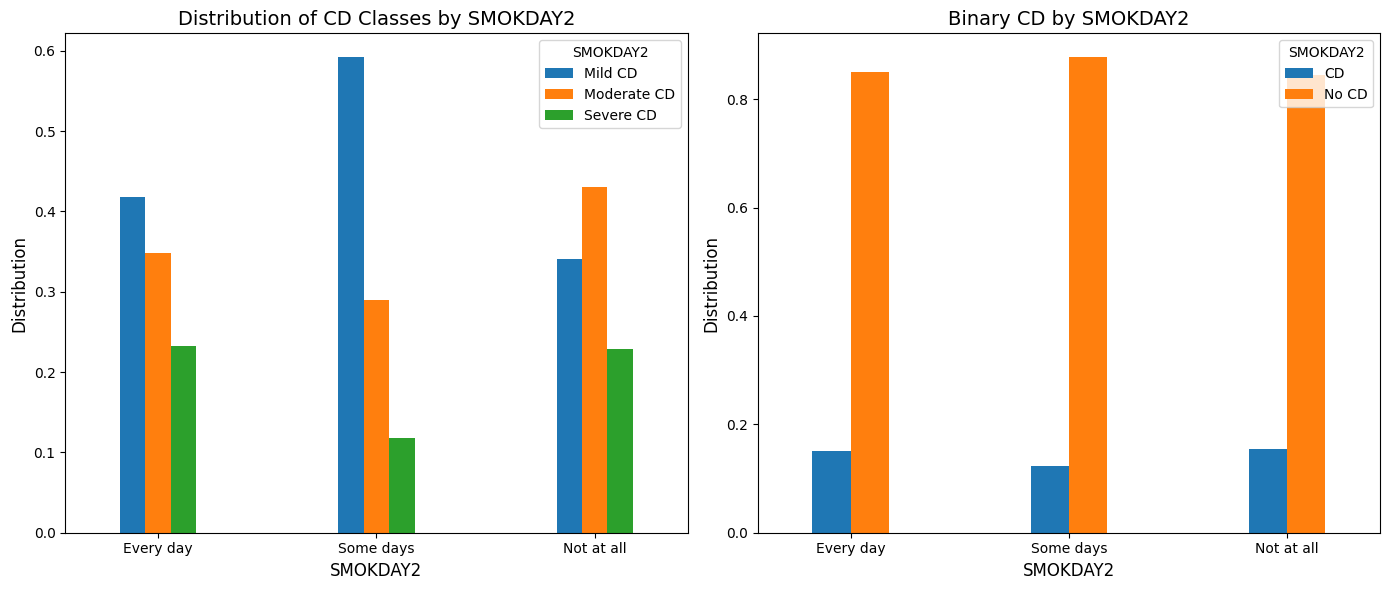

Cramers V for multi-class classification is: 0.13570820462979202
Cramers V for binary classification is: 0.036707363230886185


In [55]:
#'SMOKDAY2'-cat
mapping = {1: 'Every day', 2: 'Some days', 3: 'Not at all', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'SMOKDAY2'
explore_cat(df, feature, mapping, include_refused=False)


There are 0 missing values, 58 not sure values, 76 refused values


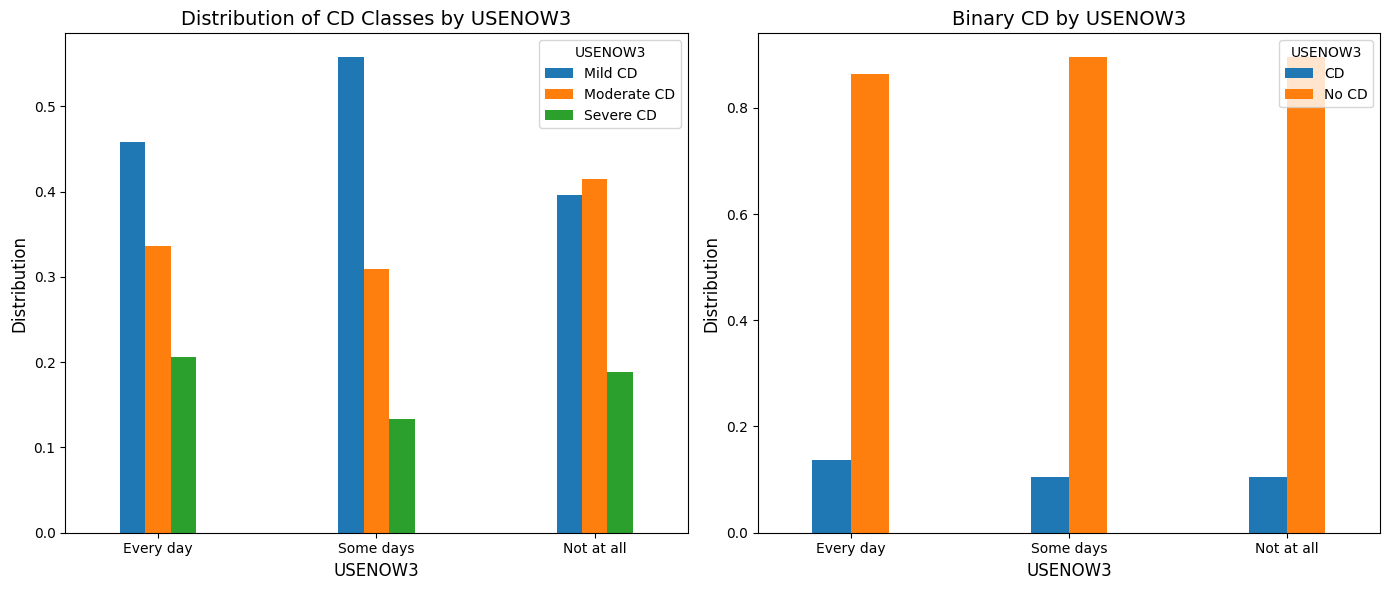

Cramers V for multi-class classification is: 0.024054585892272495
Cramers V for binary classification is: 0.010150757790240553


In [56]:
#'USENOW3'- cat
mapping = {1: 'Every day', 2: 'Some days', 3: 'Not at all', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'USENOW3'
explore_cat(df, feature, mapping, include_refused=False)



There are 0 missing values, 161 not sure values, 107 refused values


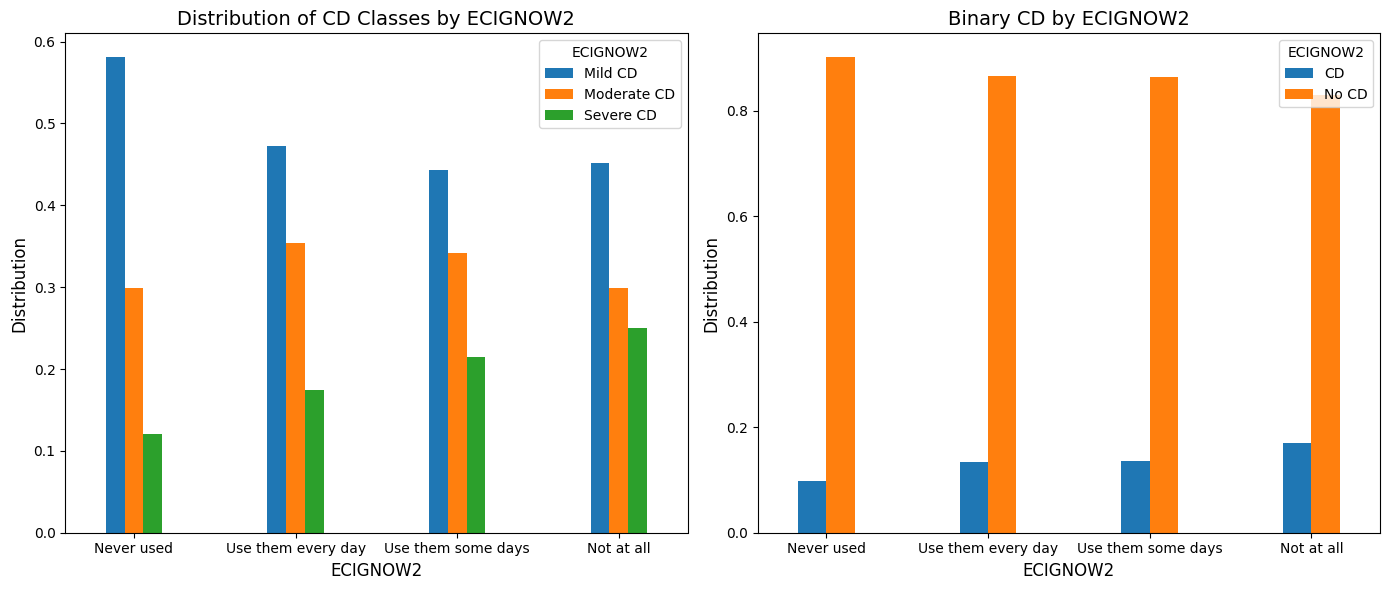

Cramers V for multi-class classification is: 0.07336222107538423
Cramers V for binary classification is: 0.04891011269539298


In [57]:
#'ECIGNOW2'-cat
mapping = {1: 'Never used', 2: 'Use them every day', 3: 'Use them some days',4:'Not at all', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'ECIGNOW2'
explore_cat(df, feature, mapping, include_refused=False)


In [58]:
df['LCSFIRST'].unique()

array([ nan,  13.,  23.,  19.,  17.,  18.,  14., 777.,  21.,  15.,  40.,
        28.,  20.,  16., 888.,   9.,  12.,  25.,   8.,  27.,  22.,  26.,
        24.,  45.,  55., 999.,  41.,  35.,  30.,  46.,  10.,  29.,  11.,
        44.,  48.,  47.,  70.,  34.,  50.,  32.,   6.,   5.,  37.,  72.,
        38.,  60.,   7.,   2.,  39.,  51.,  59.,  42.,  31.,   1.,  33.,
         4.,  52.,  49.,  43.,  58.,  36.,  53.,  56.,  73.,  64.,  88.,
        54.,  65.,   3.,  62.,  61.])

There are 35928 missing values, 514 not sure values, 77 refused values


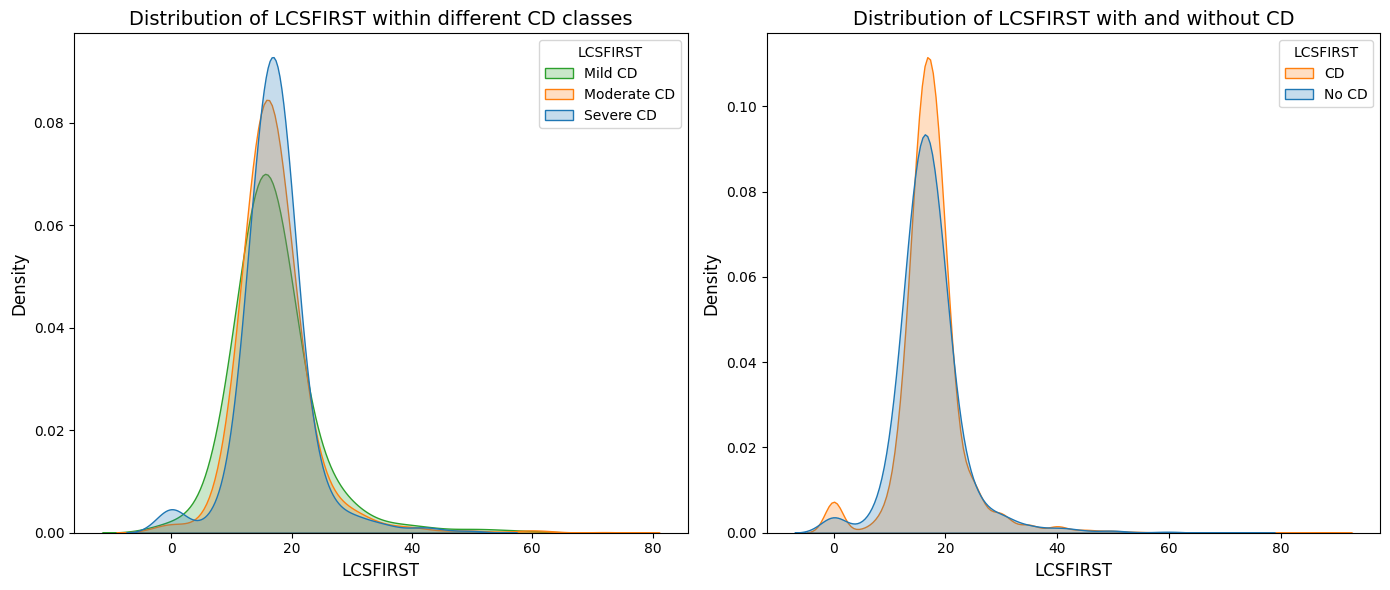

p-value for multi-class classification is: 0.8084247668443013
p-value for binary classification: 0.000459177312156502


In [59]:
#'LCSFIRST'-continuous
feature = 'LCSFIRST';

explore_cts(df, feature, none=888, not_sure=777, refused=999)

In [60]:
df['LCSLAST'] = df['LCSLAST'].fillna(888)
df['LCSLAST'].unique()

array([888., 777.,  61.,  50.,  30.,  36.,  70.,  65.,  80.,  52.,  20.,
        35.,  32.,  60.,  40.,  62.,  29.,  25.,  42.,  51.,  45.,  73.,
        66.,  53.,  26.,  21.,  19.,  48.,  23.,  67.,  28.,  58.,  22.,
        14.,  18.,  24.,  64.,  56.,  71.,  77.,  41.,  69.,  59.,  75.,
        34.,  31.,  27.,  76., 999.,  79.,  44.,  16.,  72.,  49.,  55.,
        88.,  15.,  78.,  68.,  46.,  43.,  54.,  63.,  47.,  57.,  33.,
        38.,  12.,  74.,  37.,  39.,  81.,  17.,  83.,  85.,  82.,   6.,
        13.,   9.,   1.,  87.,   7.,  86.,  89.,  90.,  11.,  84.,  99.,
         5.,   2.,  10.,   8.,  92.,  93.])

There are 0 missing values, 902 not sure values, 152 refused values


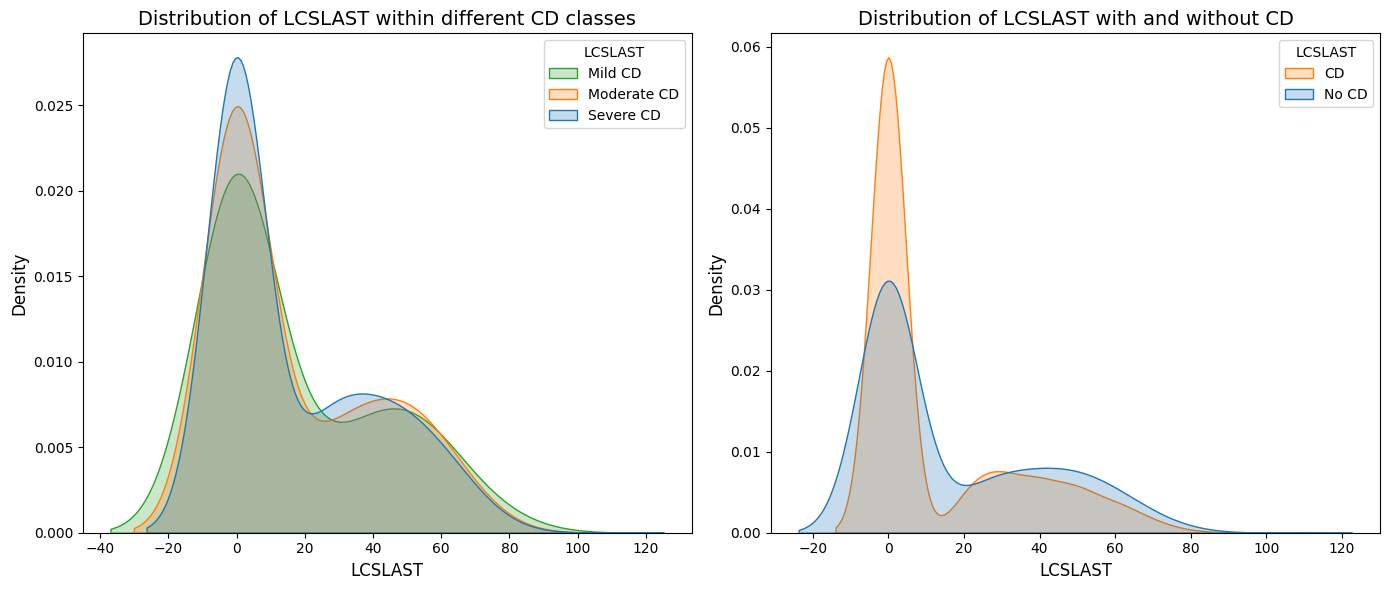

p-value for multi-class classification is: 0.9646138890436697
p-value for binary classification: 1.1862885633565268e-40


In [61]:
#'LCSLAST'-continuous
feature = 'LCSLAST';

explore_cts(df, feature, none=888, not_sure=777, refused=999)

In [62]:
df['LCSNUMCG'] = df['LCSNUMCG'].fillna(888)
df['LCSNUMCG'].unique()

array([888.,  15.,  20.,  10.,  25.,  30.,   5.,   6.,   7., 999., 777.,
         4.,  60.,  50.,  40.,  13.,   3.,  12.,   1.,  17.,  80.,   2.,
        45.,   8.,   9., 100.,  18.,  55.,  11.,  16., 205.,  90., 160.,
        14., 120., 180., 130.,  35., 105.,  24.,  75., 300.,  56., 240.,
       103.,  79.,  19.,  29.,  65., 220., 190., 112., 243., 115., 101.,
       110., 175., 153.,  22.,  77.,  27.,  70., 125., 203.,  34.,  36.,
       118., 200., 107., 108.,  37.,  28.,  21.,  43.,  23.,  48., 201.,
       225.,  63.,  26.,  59.,  99.])

There are 0 missing values, 965 not sure values, 115 refused values


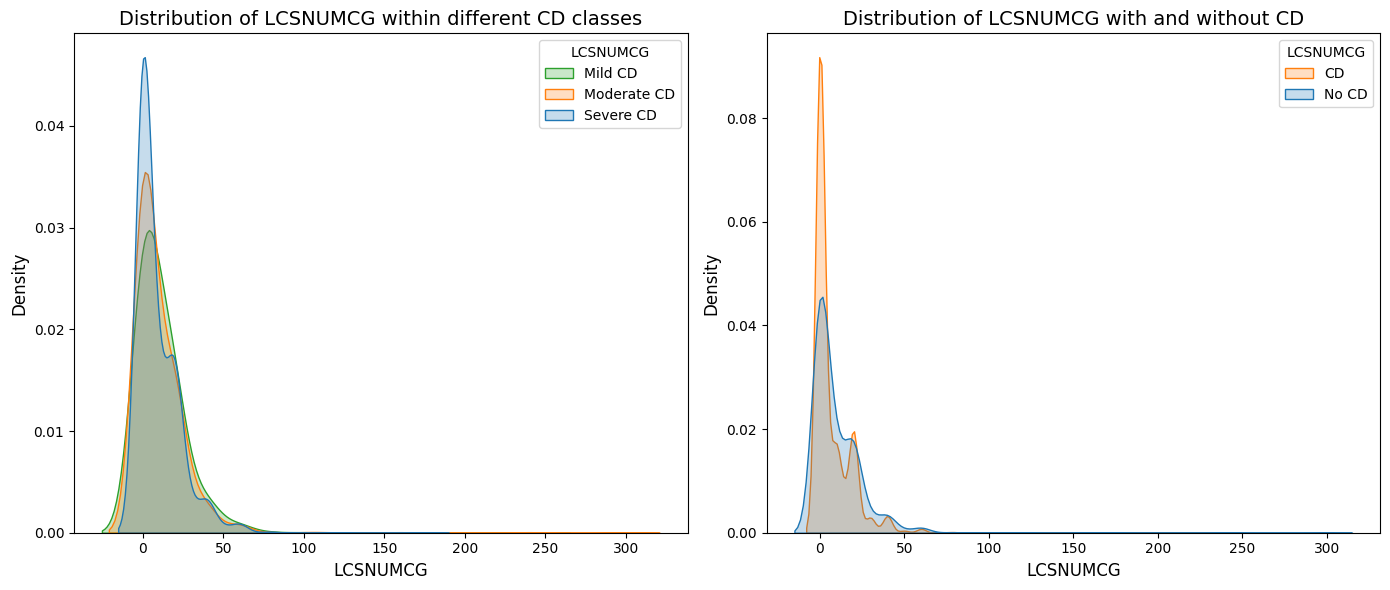

p-value for multi-class classification is: 8.491755911528765e-05
p-value for binary classification: 1.7650203076462315e-68


In [63]:
#'LCSNUMCG'-continuous
feature = 'LCSNUMCG';

explore_cts(df, feature, none=888, not_sure=777, refused=999)

There are 0 missing values, 3021 not sure, 70 refused


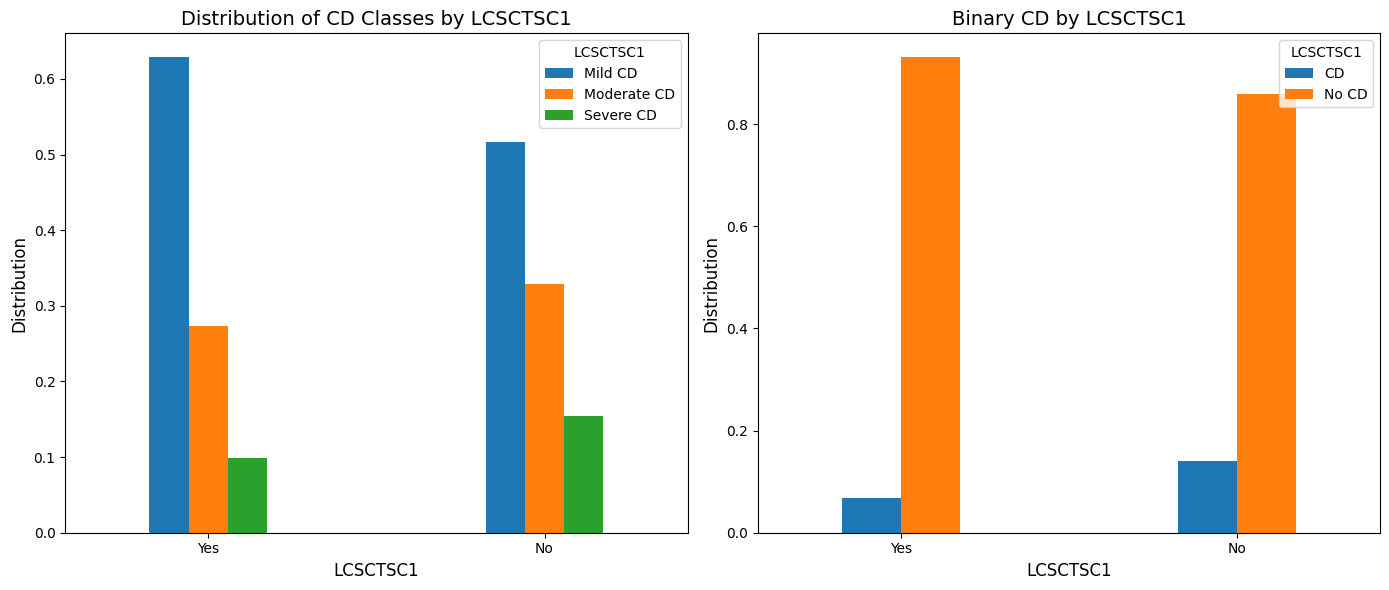

Cramers V for multi-class classification is: 0.11027015574237692
Cramers V for binary classification is: 0.11784301552956081


In [64]:
#'LCSCTSC1'-binary
explore_binary(df, 'LCSCTSC1', include_refused=False)

There are 33433 missing values, 1906 not sure, 15 refused


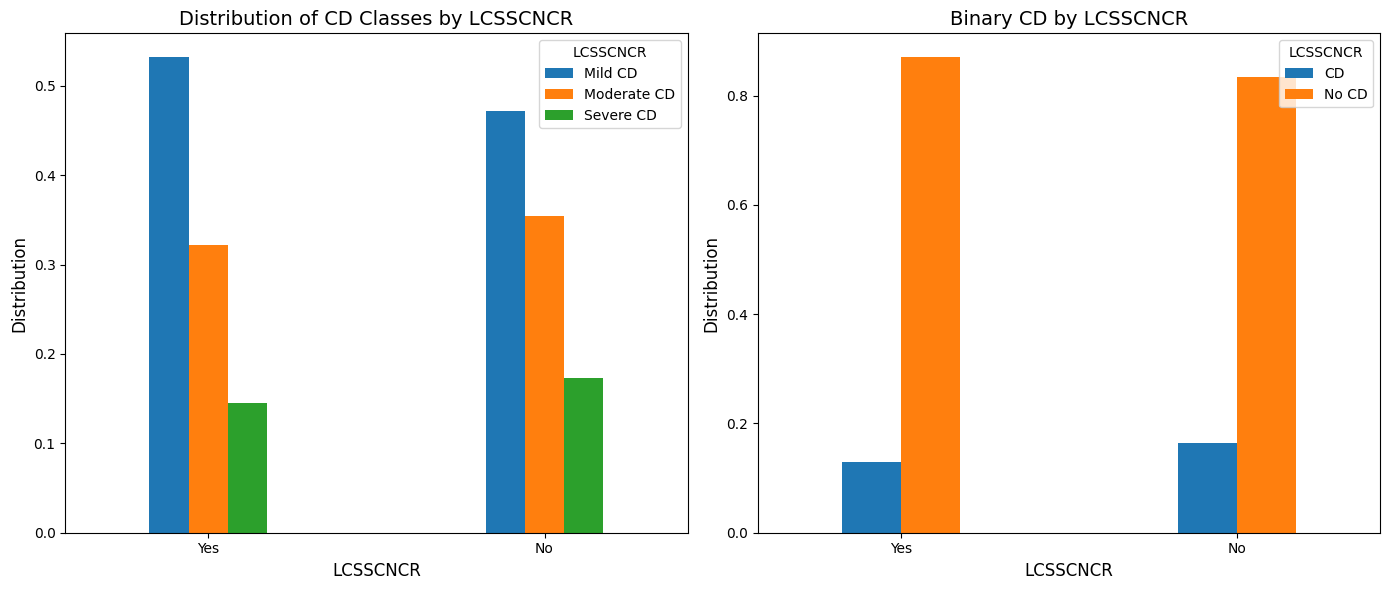

Cramers V for multi-class classification is: 0.0505437474678508
Cramers V for binary classification is: 0.04319622882757596


In [65]:
#'LCSSCNCR'-binary
explore_binary(df, 'LCSSCNCR', include_refused=False)

There are 56958 missing values, 235 not sure values, 9 refused values


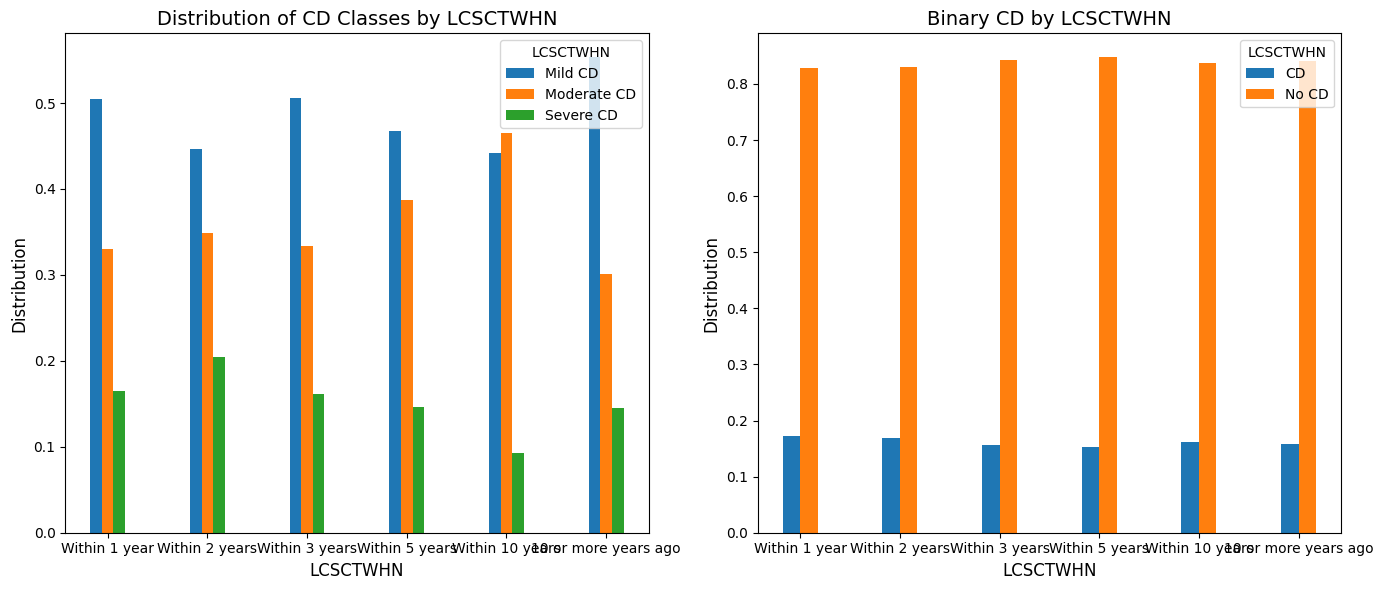

Cramers V for multi-class classification is: 0.04649710336656153
Cramers V for binary classification is: 0.0


In [66]:
#'LCSCTWHN'-cat
mapping = {1: 'Within 1 year', 2: 'Within 2 years', 3: 'Within 3 years',4: 'Within 5 years', 5: 'Within 10 years',6:'10 or more years ago', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'LCSCTWHN'
explore_cat(df, feature, mapping, include_refused=False)

In [67]:
#'ALCDAY4'

In [68]:
df['AVEDRNK3'] = df['AVEDRNK3'].fillna(88)
df['AVEDRNK3'].unique()


array([ 1., 88.,  2.,  4.,  6.,  7.,  3., 30.,  5., 77.,  8., 11., 16.,
       99., 10., 12., 14., 24., 50., 20., 76., 15., 25., 33.,  9., 18.,
       23., 60., 28., 32., 22., 17., 72., 65., 35., 26.])

There are 0 missing values, 240 not sure values, 83 refused values


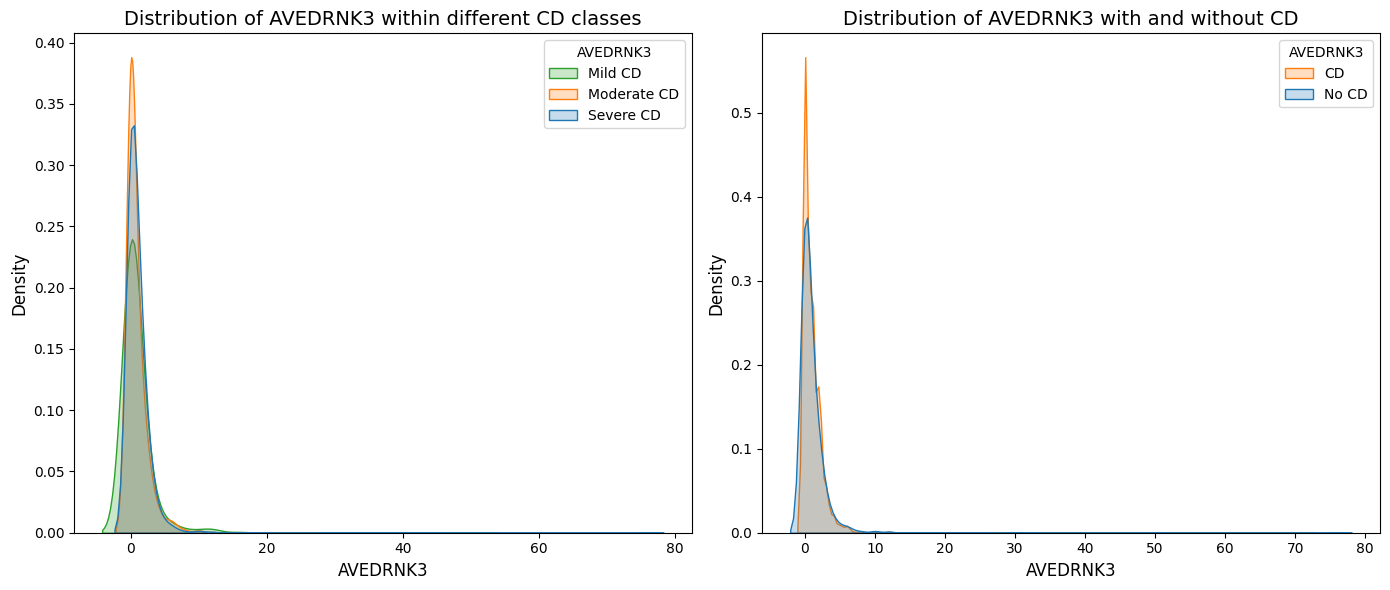

p-value for multi-class classification is: 0.0692637159012318
p-value for binary classification: 0.17557644593174004


In [70]:
#'AVEDRNK3'-continuous
feature = 'AVEDRNK3';

explore_cts(df, feature, none=88, not_sure=77, refused=99)

In [72]:
df['DRNK3GE5'] = df['DRNK3GE5'].fillna(88)
df['DRNK3GE5'].unique()


array([88.,  2., 25., 30.,  3.,  1., 20.,  4., 10., 77., 99.,  8.,  6.,
        7.,  5., 29.,  9., 16., 15., 28., 11., 12., 14., 27., 18., 21.,
       24., 22., 26., 60., 13., 17., 70., 23.])

There are 0 missing values, 389 not sure values, 88 refused values


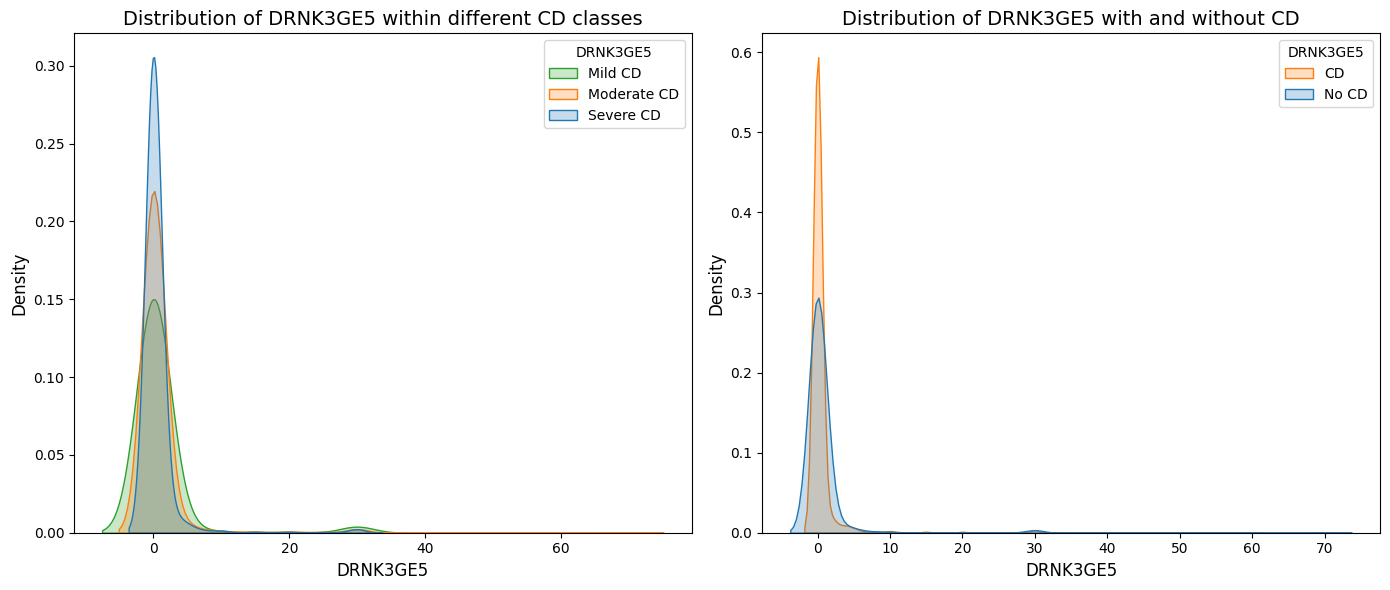

p-value for multi-class classification is: 0.00460813150581686
p-value for binary classification: 2.2623149320804945e-08


In [73]:
#'DRNK3GE5'-continuous
feature = 'DRNK3GE5';

explore_cts(df, feature, none=88, not_sure=77, refused=99)


In [78]:
df['MAXDRNKS'] = df['MAXDRNKS'].fillna(88)
df['MAXDRNKS'].unique()

array([1.00000000e+00, 8.80000000e+01, 2.00000000e+00, 6.00000000e+00,
       3.00000000e+00, 7.00000000e+00, 7.70000000e+01, 5.00000000e+00,
       4.00000000e+00, 8.00000000e+00, 3.00000000e+01, 1.00000000e+01,
       1.20000000e+01, 9.90000000e+01, 1.60000000e+01, 2.40000000e+01,
       1.70000000e+01, 2.50000000e+01, 1.50000000e+01, 2.00000000e+01,
       1.80000000e+01, 9.00000000e+00, 1.10000000e+01, 4.80000000e+01,
       1.30000000e+01, 1.40000000e+01, 3.60000000e+01, 5.39760535e-79,
       2.30000000e+01, 2.20000000e+01, 4.00000000e+01, 2.10000000e+01,
       3.20000000e+01, 6.40000000e+01, 5.00000000e+01, 3.50000000e+01])

There are 0 missing values, 710 not sure values, 169 refused values


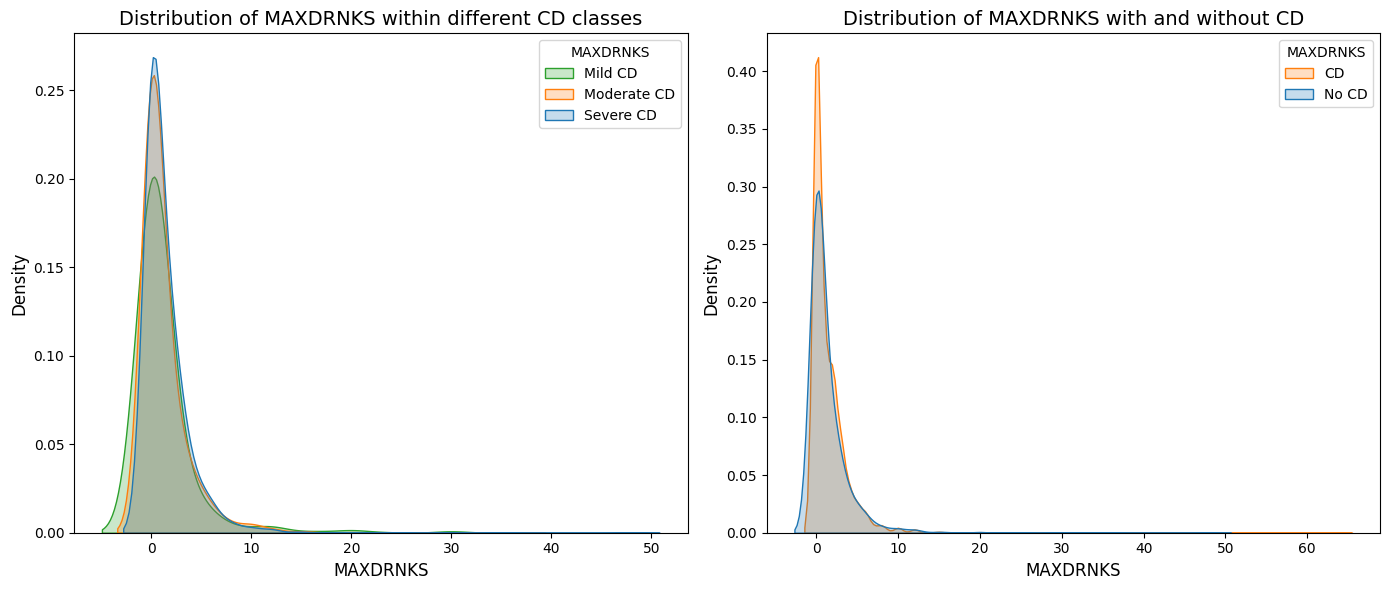

p-value for multi-class classification is: 0.022006674941573455
p-value for binary classification: 0.06911323433923831


In [79]:
#'MAXDRNKS'-continuous
feature = 'MAXDRNKS';

explore_cts(df, feature, none=88, not_sure=77, refused=99)

There are 0 missing values, 336 not sure, 102 refused


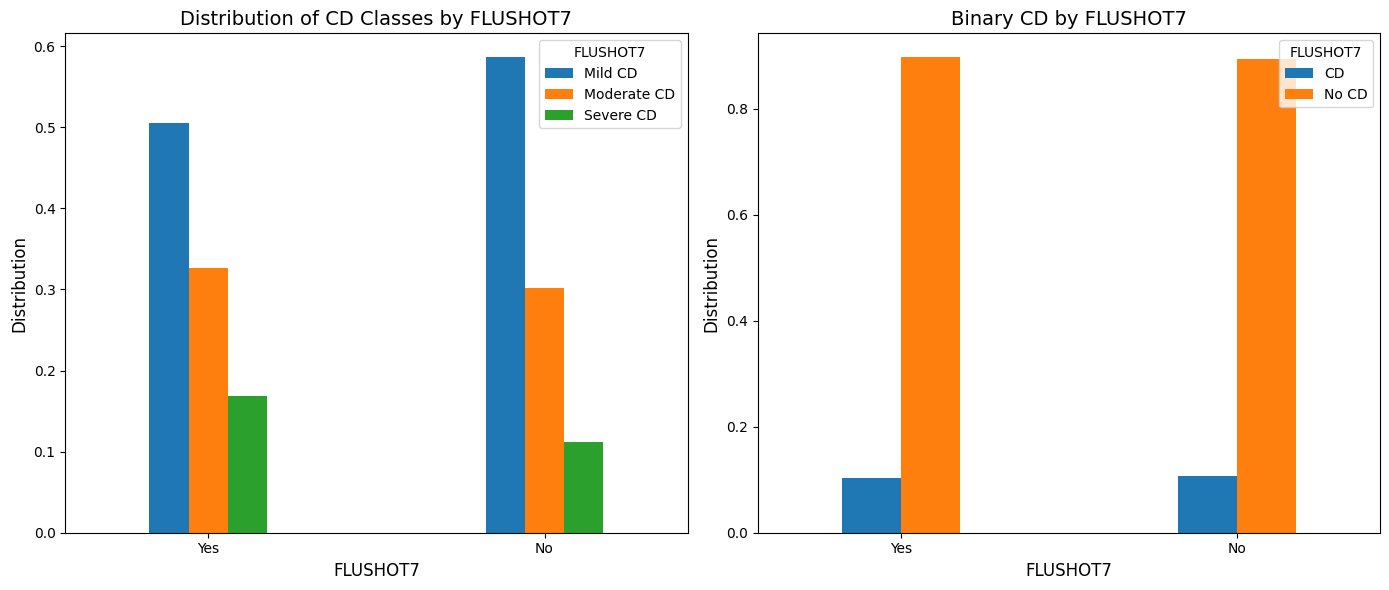

Cramers V for multi-class classification is: 0.09292677892491846
Cramers V for binary classification is: 0.0029750684122696745


In [80]:
#'FLUSHOT7'-binary
explore_binary(df, 'FLUSHOT7', include_refused=False)

In [69]:
#'FLSHTMY3'

There are 0 missing values, 2805 not sure, 72 refused


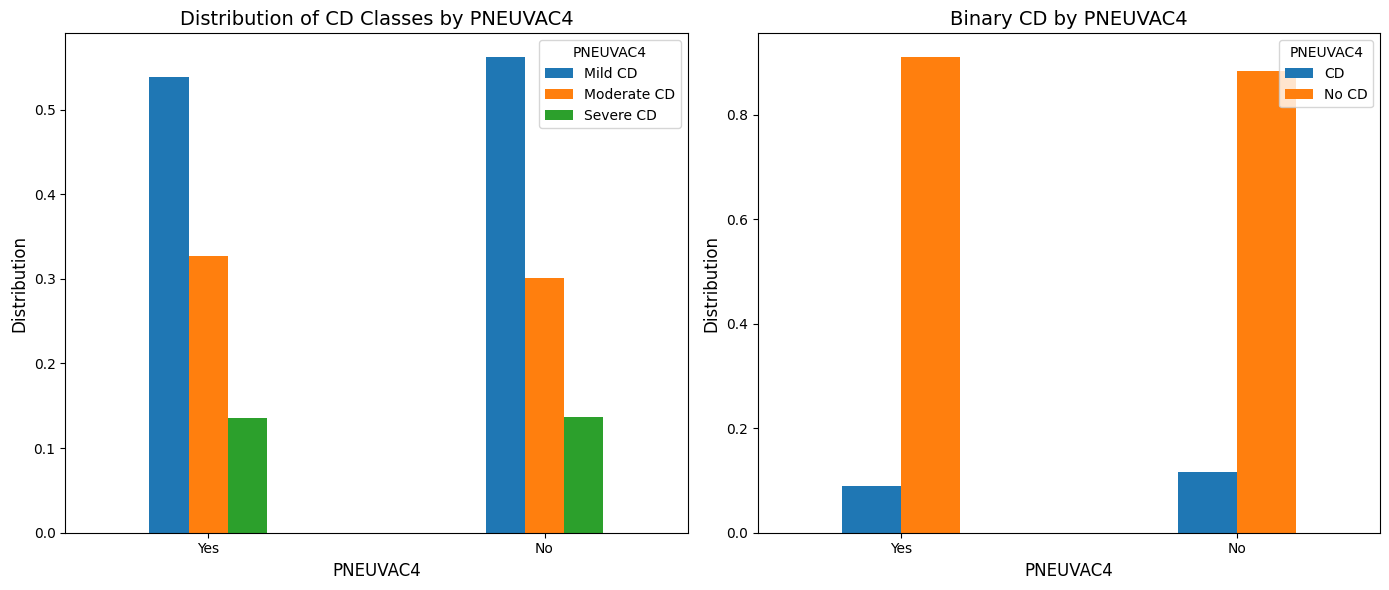

Cramers V for multi-class classification is: 0.020970133571781836
Cramers V for binary classification is: 0.042762373607868755


In [81]:
#'PNEUVAC4'-binary
explore_binary(df, 'PNEUVAC4', include_refused=False)


There are 0 missing values, 5698 not sure values, 68 refused values


<ipython-input-10-d0a7d89988d7>:48: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


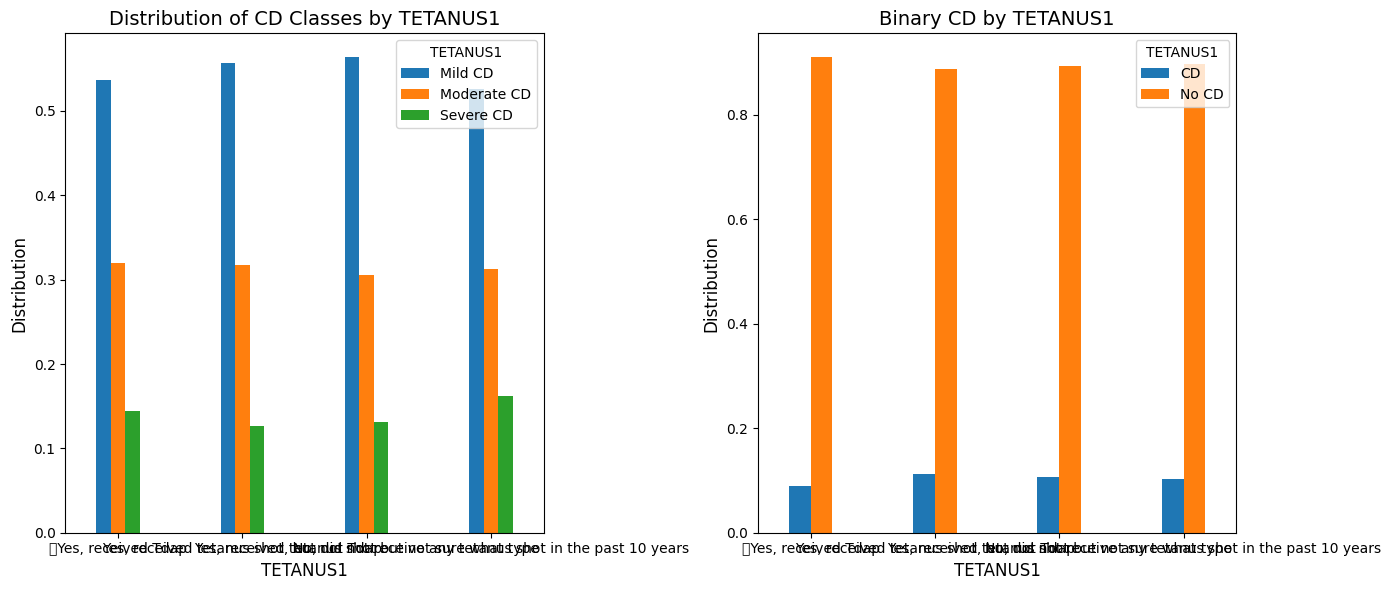

Cramers V for multi-class classification is: 0.010516238562140116
Cramers V for binary classification is: 0.028602266447823255


In [82]:
#'TETANUS1' -cat
mapping = {1: '	Yes, received Tdap', 2: 'Yes, received tetanus shot, but not Tdap', 3: 'Yes, received tetanus shot but not sure what type',
           4: 'No, did not receive any tetanus shot in the past 10 years', 7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'TETANUS1'
explore_cat(df, feature, mapping, include_refused=False)

There are 0 missing values, 3497 not sure, 80 refused


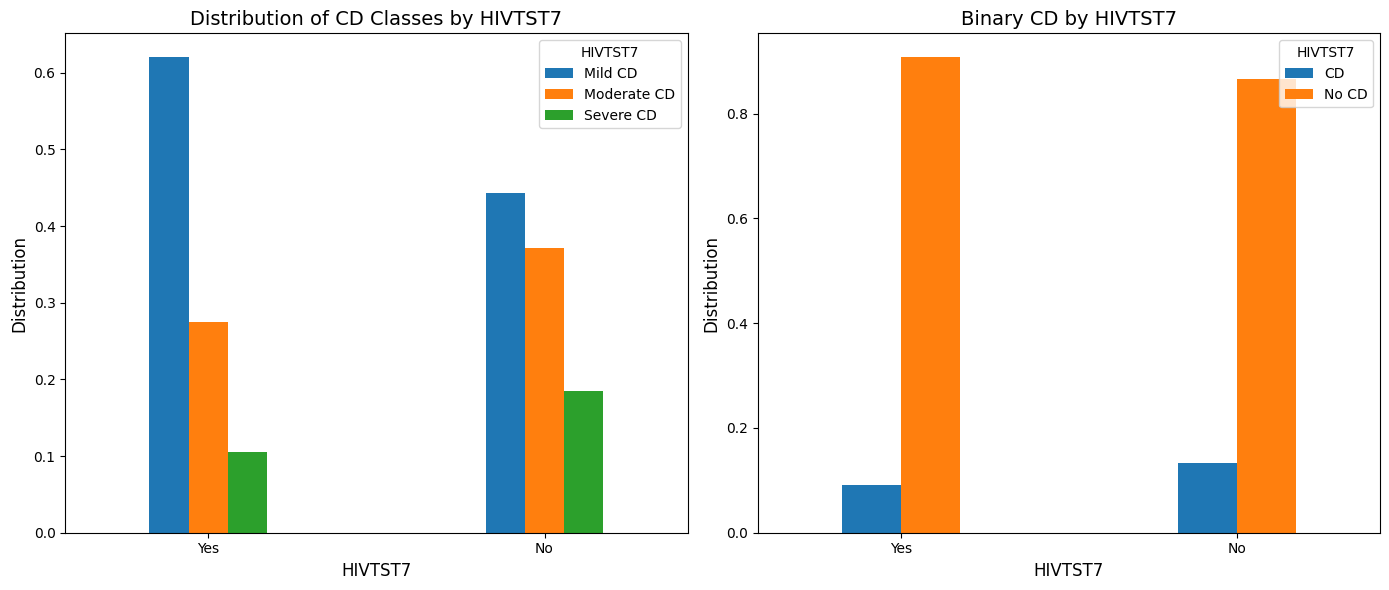

Cramers V for multi-class classification is: 0.1752168665126862
Cramers V for binary classification is: 0.06151272851742452


In [83]:
#'HIVTST7'-binary
explore_binary(df, 'HIVTST7', include_refused=False)

In [69]:
#'HIVTSTD3'

There are 0 missing values, 50 not sure, 216 refused


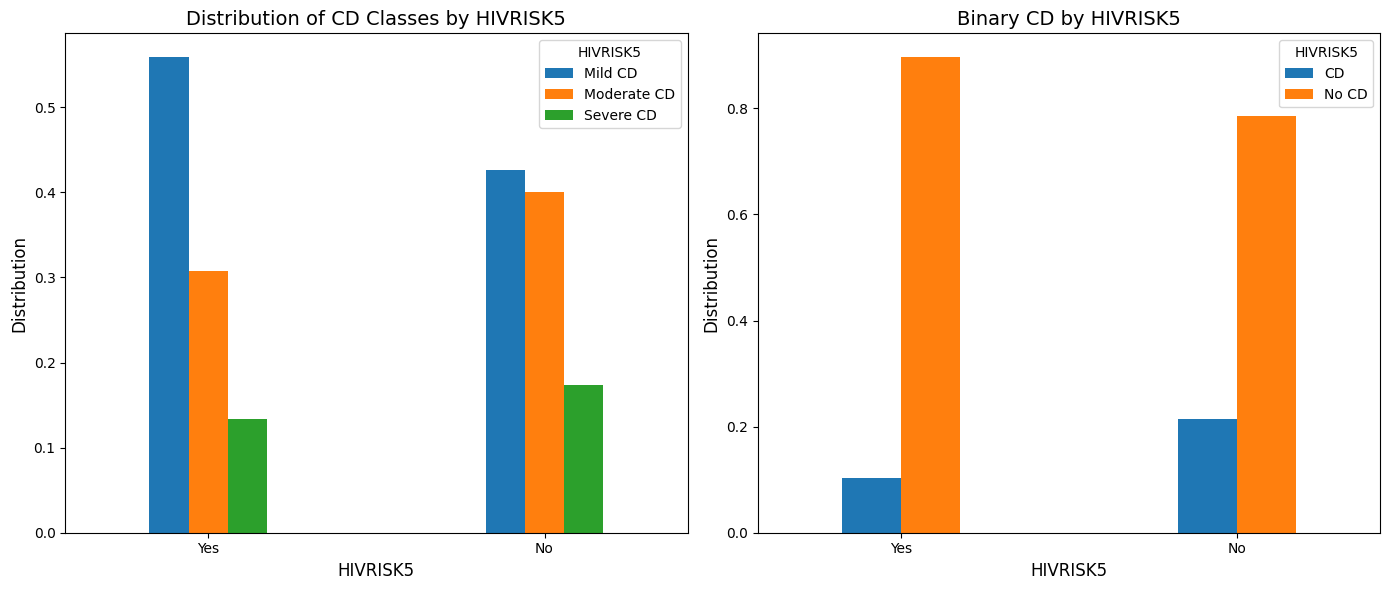

Cramers V for multi-class classification is: 0.044867696143966414
Cramers V for binary classification is: 0.04583724159067888


In [84]:
#'HIVRISK5'-binary
explore_binary(df, 'HIVRISK5', include_refused=False)

There are 0 missing values, 93 not sure values, 72 refused values


<ipython-input-10-d0a7d89988d7>:48: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


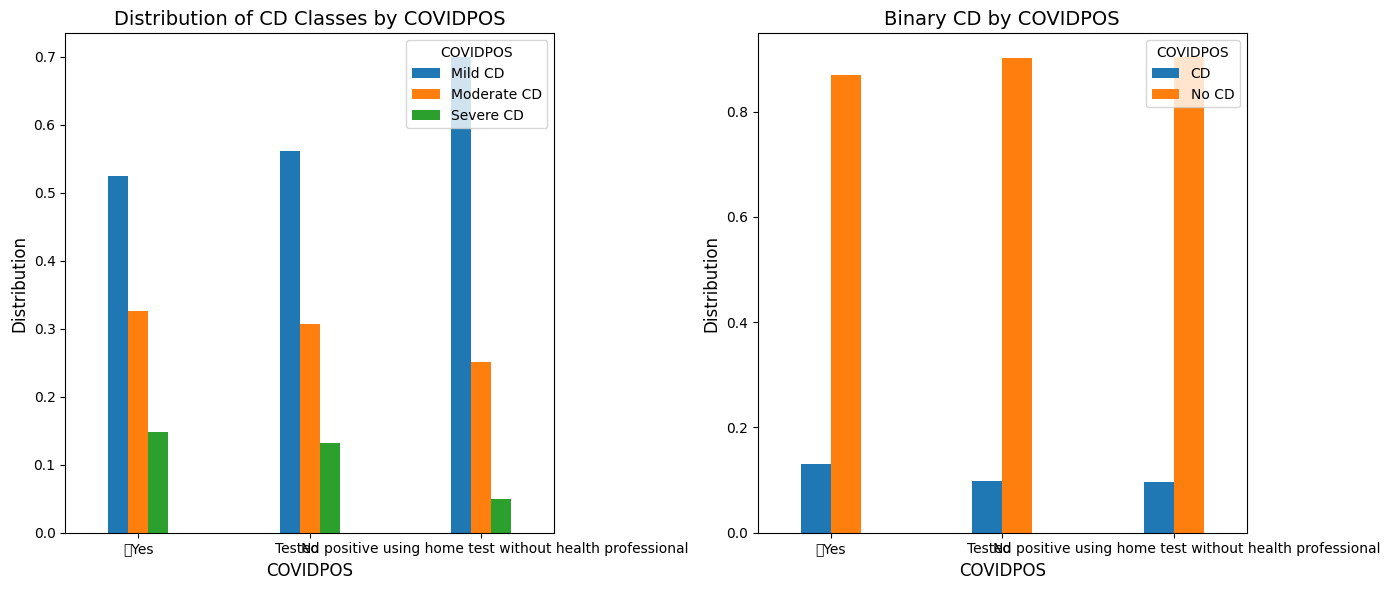

Cramers V for multi-class classification is: 0.04342783398802959
Cramers V for binary classification is: 0.044054280867089984


In [95]:
#'COVIDPOS'-cat
mapping = {1: '	Yes', 2: 'No', 3: 'Tested positive using home test without health professional',7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Tested positive using home test",7: "Not Sure", 9: "Refused"}
feature = 'COVIDPOS'
explore_cat(df, feature, mapping, include_refused=False)


There are 47081 missing values, 441 not sure, 12 refused


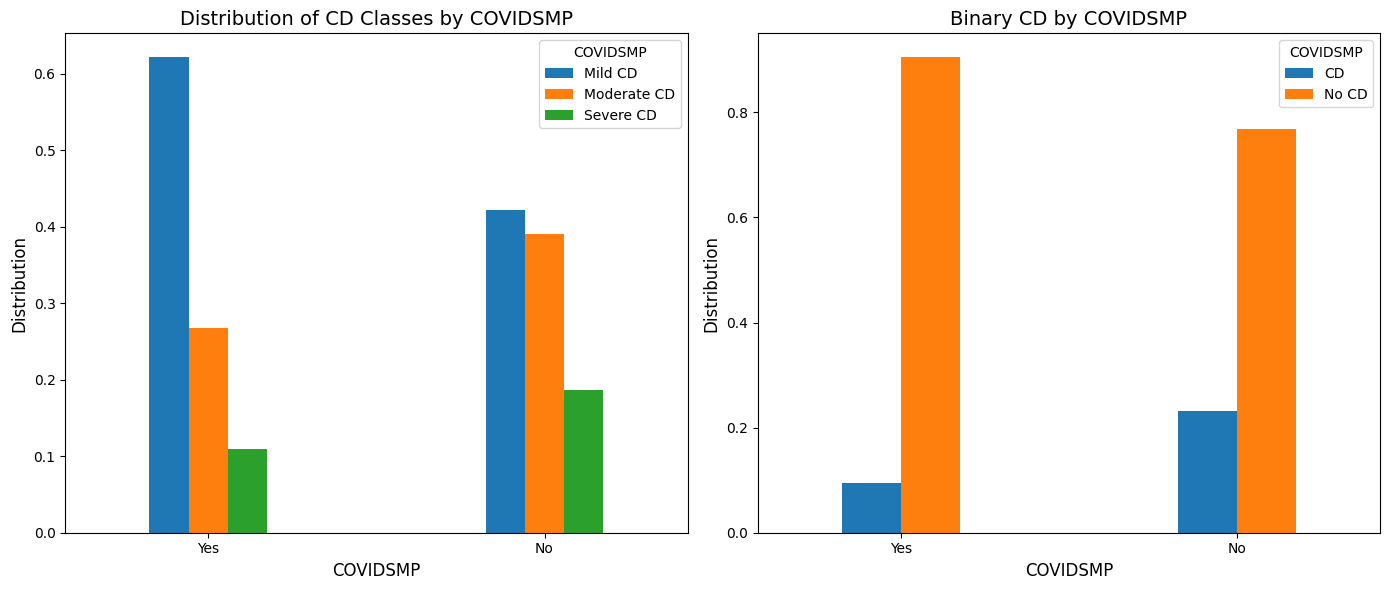

Cramers V for multi-class classification is: 0.19573529818789603
Cramers V for binary classification is: 0.17064975434896007


In [87]:
#'COVIDSMP'-binary
explore_binary(df, 'COVIDSMP', include_refused=False)


There are 0 missing values, 109 not sure values, 15 refused values


<ipython-input-10-d0a7d89988d7>:48: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


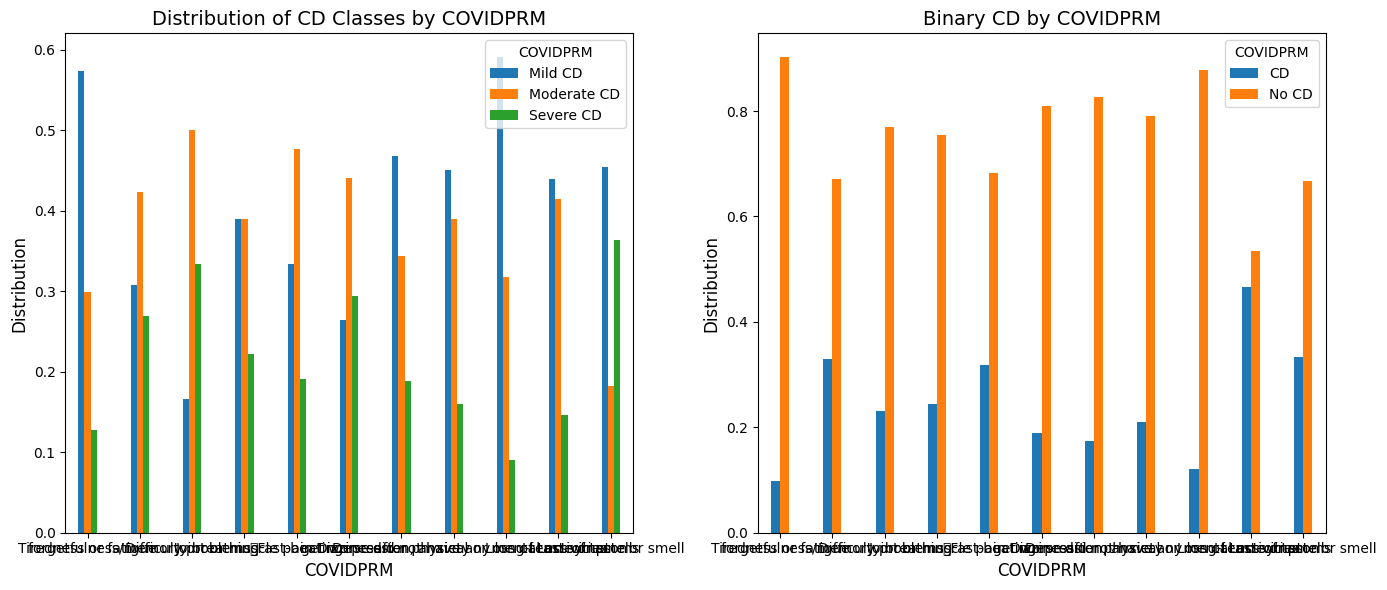

Cramers V for multi-class classification is: 0.07065883768655719
Cramers V for binary classification is: 0.11860792616801016


In [92]:

#'COVIDPRM'-cat
df['COVIDPRM'] = df['COVIDPRM'].fillna(88)
mapping = {1: 'Tiredness or fatigue', 2: 'forgetfulness/memory problems', 3: 'Difficulty breathing',4:'Joint or muscle pain',5:'	Fast-beating',
           6:'Dizziness',7:'Depression, anxiety',8:'get worse after physical or mental activities',9:'did not have any long-term symptoms',
           10:'Loss of taste or smell',11:'Loss of taste or smell',77: "Not Sure", 99: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Tested positive using home test",7: "Not Sure", 9: "Refused"}
feature = 'COVIDPRM'
explore_cat(df, feature, mapping, include_refused=False)

There are 37471 missing values, 1249 not sure values, 27 refused values


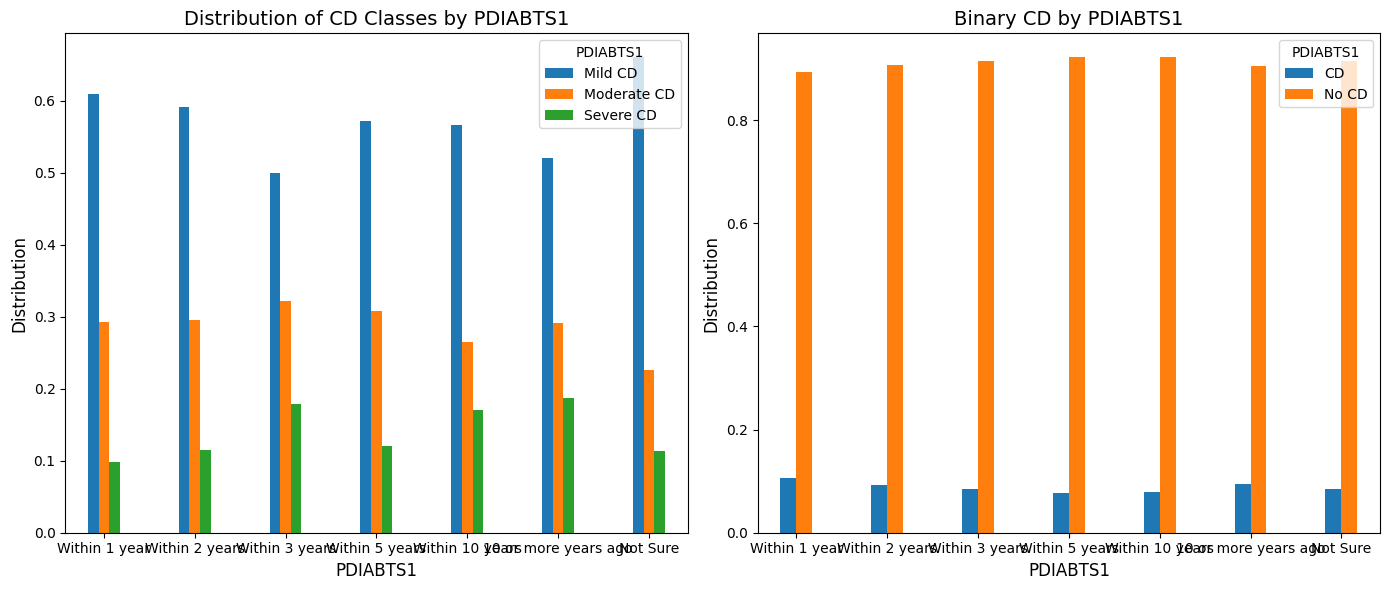

Cramers V for multi-class classification is: 0.0
Cramers V for binary classification is: 0.00912056034504101


In [93]:
#'PDIABTS1'-cat
mapping = {1: 'Within 1 year', 2: 'Within 2 years', 3: 'Within 3 years',4: 'Within 5 years',5:'Within 10 years', 6:'10 or more years ago', 7: "Not Sure",8:'never', 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Tested positive using home test",7: "Not Sure", 9: "Refused"}
feature = 'PDIABTS1'
explore_cat(df, feature, mapping, include_refused=False)

There are 37472 missing values, 131 not sure values, 19 refused values


<ipython-input-10-d0a7d89988d7>:48: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


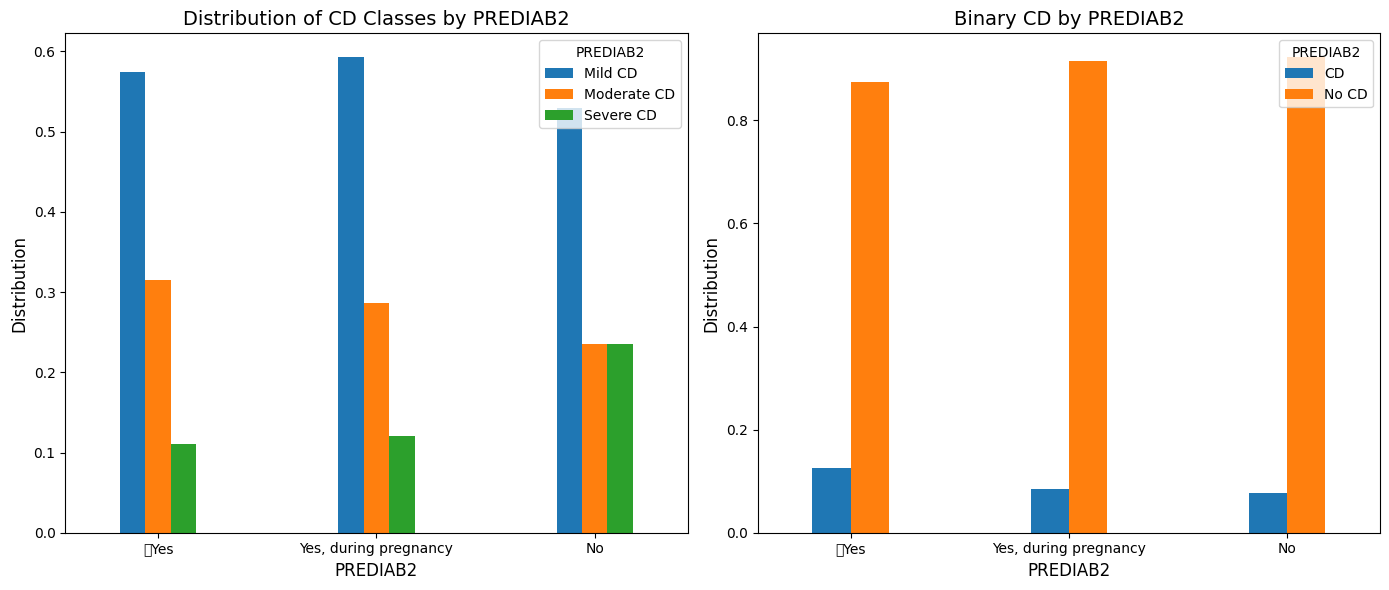

Cramers V for multi-class classification is: 0.0
Cramers V for binary classification is: 0.05360741380626901


In [94]:
#'PREDIAB2'-cat
mapping = {1: '	Yes', 2: 'Yes, during pregnancy', 3: 'No',7: "Not Sure", 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Tested positive using home test",7: "Not Sure", 9: "Refused"}
feature = 'PREDIAB2'
explore_cat(df, feature, mapping, include_refused=False)

There are 57739 missing values, 397 not sure, 14 refused


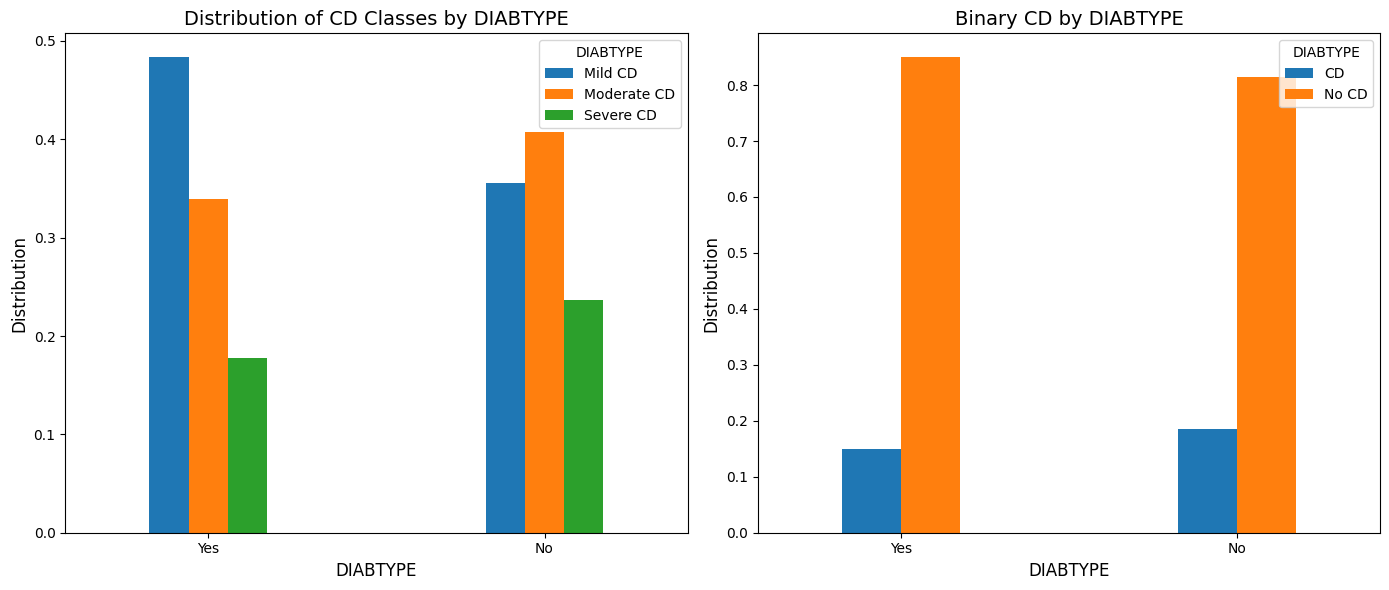

Cramers V for multi-class classification is: 0.056757517220600004
Cramers V for binary classification is: 0.021217530667423875


In [96]:
#'DIABTYPE'-binary
explore_binary(df, 'DIABTYPE', include_refused=False)

There are 57739 missing values, 19 not sure, 5 refused


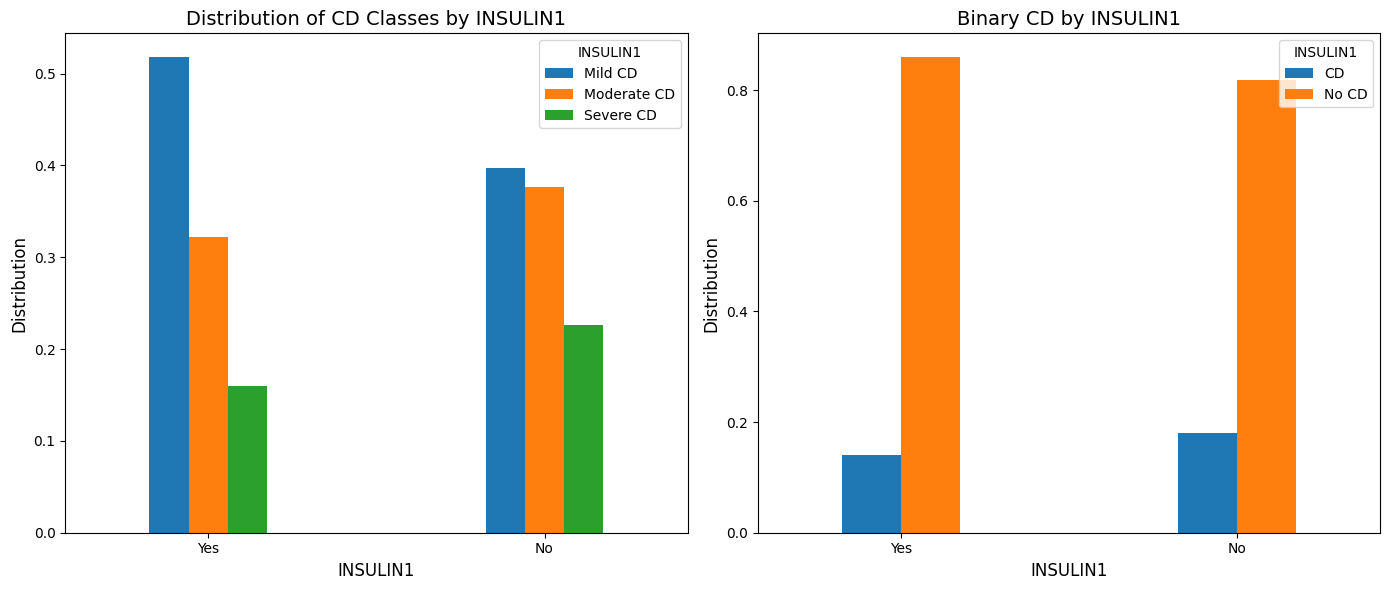

Cramers V for multi-class classification is: 0.11288063548321034
Cramers V for binary classification is: 0.050798932406700616


In [97]:
#'INSULIN1'-binary
explore_binary(df, 'INSULIN1', include_refused=False)

In [99]:
#'CHKHEMO3'-continuous
df['CHKHEMO3'] = df['CHKHEMO3'].replace(98, 77)
df['CHKHEMO3'].unique()

array([nan,  4.,  1., 88.,  2., 77.,  3., 14., 76.,  8.,  7., 28.,  5.,
       10.,  6., 12., 99., 20., 60., 22., 30., 74., 23., 21.,  9., 24.,
       11., 36., 15., 52., 54., 13., 25.])

There are 57739 missing values, 290 not sure values, 22 refused values


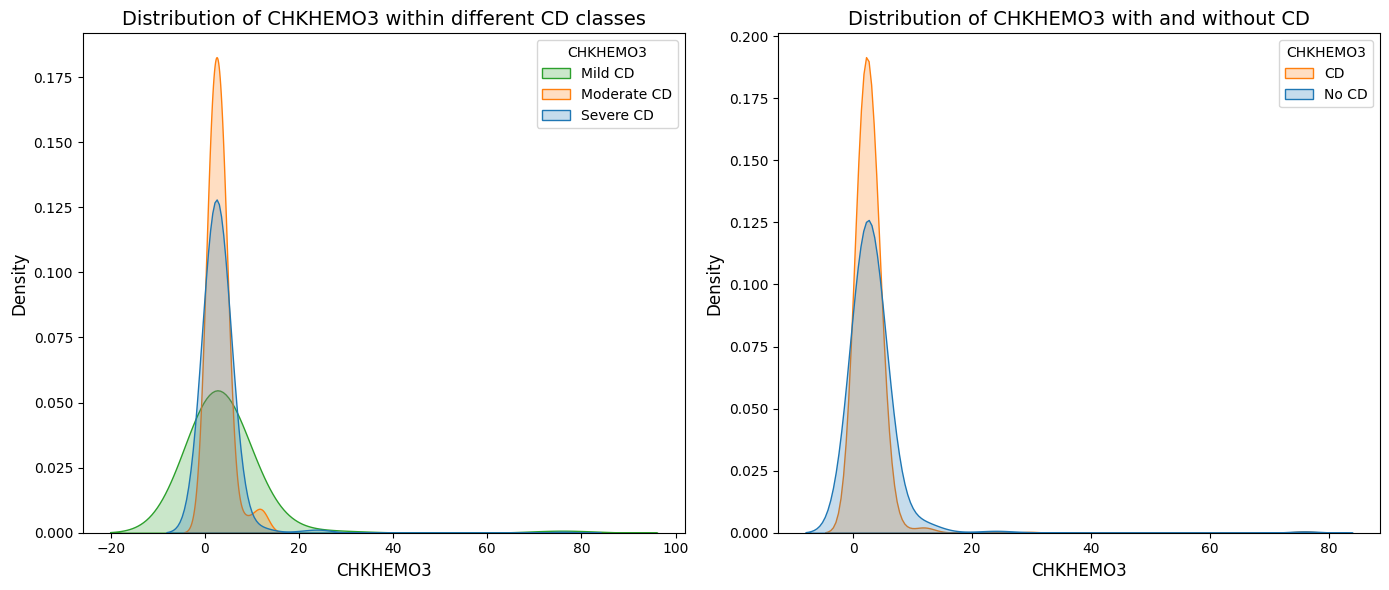

p-value for multi-class classification is: 0.021466323092810984
p-value for binary classification: 0.0075011882251748594


In [100]:
feature = 'CHKHEMO3';

explore_cts(df, feature, none=88, not_sure=77, refused=99)

There are 57739 missing values, 107 not sure values, 3 refused values


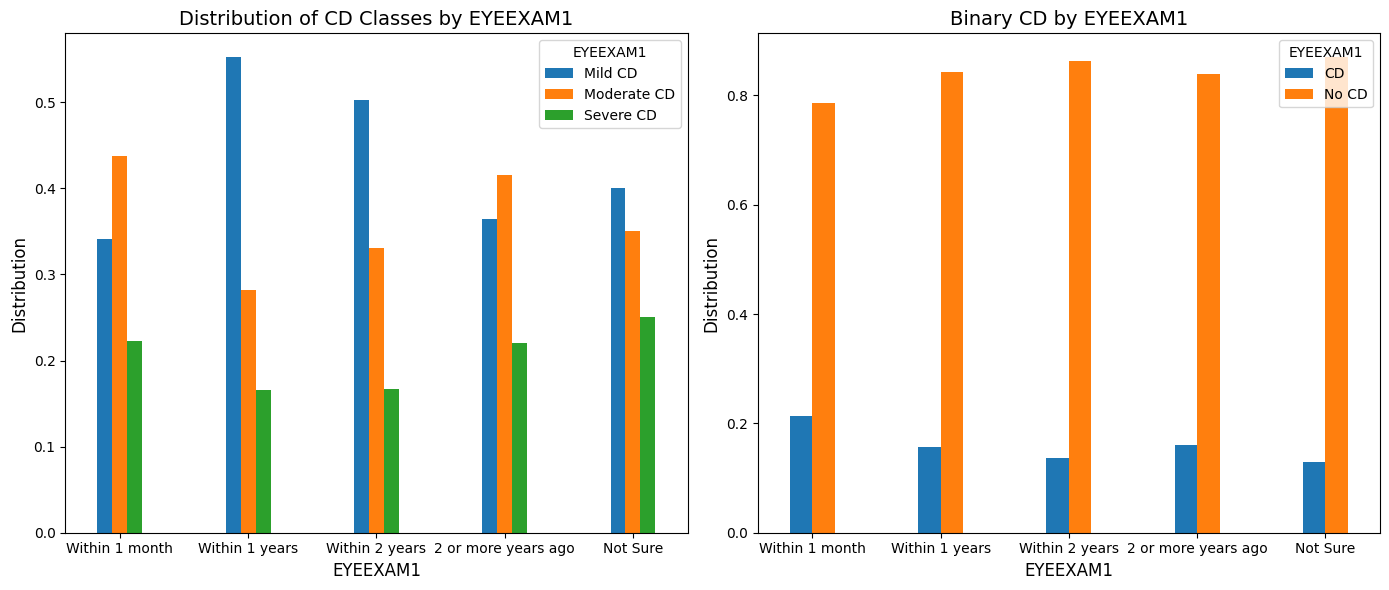

Cramers V for multi-class classification is: 0.09418025666032341
Cramers V for binary classification is: 0.059491212731822875


In [101]:
#'EYEEXAM1'-cat
mapping = {1: 'Within 1 month', 2: 'Within 1 years', 3: 'Within 2 years',4: '2 or more years ago', 7: "Not Sure",8:'never', 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Tested positive using home test",7: "Not Sure", 9: "Refused"}
feature = 'EYEEXAM1'
explore_cat(df, feature, mapping, include_refused=False)

There are 57739 missing values, 745 not sure values, 4 refused values


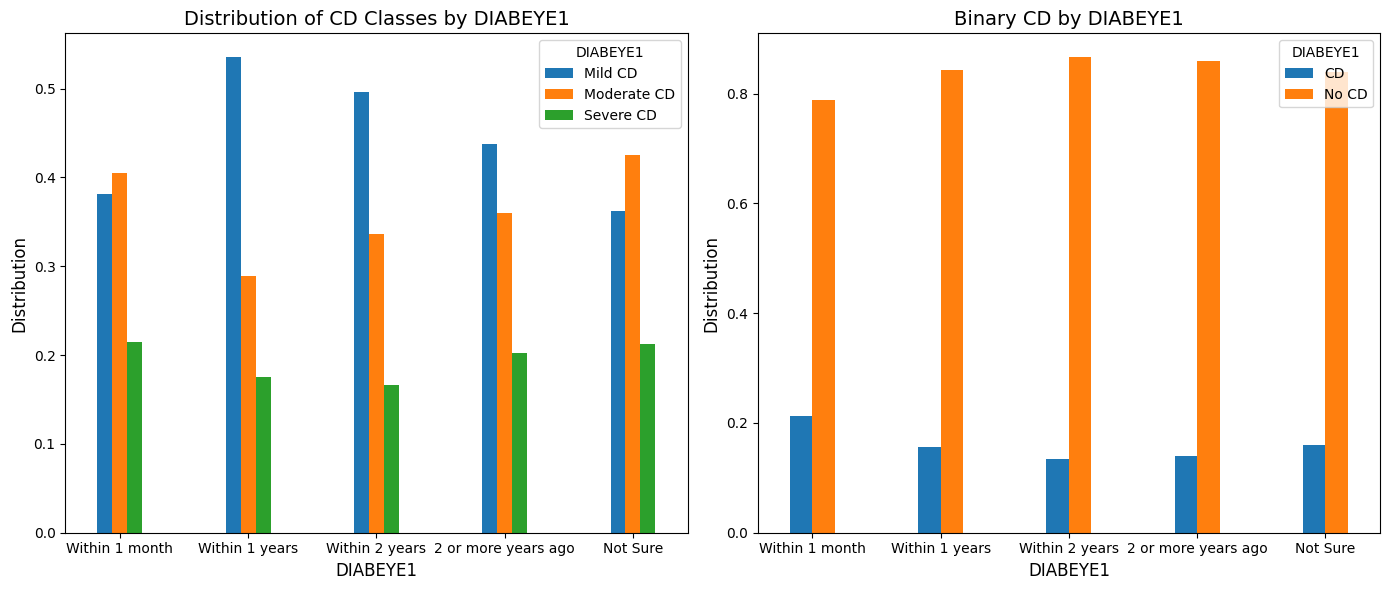

Cramers V for multi-class classification is: 0.05437803812824664
Cramers V for binary classification is: 0.06187521612268818


In [102]:
#'DIABEYE1'-cat
mapping = {1: 'Within 1 month', 2: 'Within 1 years', 3: 'Within 2 years',4: '2 or more years ago', 7: "Not Sure",8:'never', 9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Tested positive using home test",7: "Not Sure", 9: "Refused"}
feature = 'DIABEYE1'
explore_cat(df, feature, mapping, include_refused=False)

There are 57739 missing values, 263 not sure values, 11 refused values


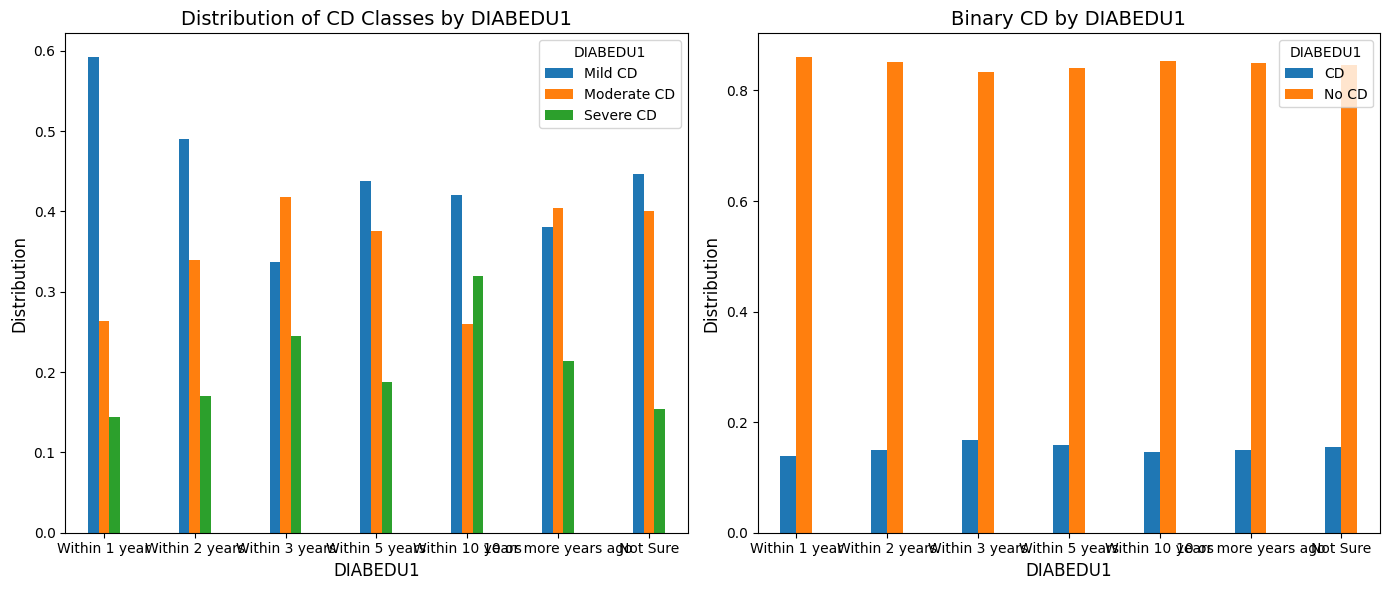

Cramers V for multi-class classification is: 0.0854074120617985
Cramers V for binary classification is: 0.0


In [105]:
#'DIABEDU1'
mapping = {1: 'Within 1 year', 2: 'Within 2 years', 3: 'Within 3 years',4: 'Within 5 years', 5: 'Within 10 years',6:'10 or more years ago', 7: "Not Sure", 8:'Never',9: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'DIABEDU1'
explore_cat(df, feature, mapping, include_refused=False)

There are 57739 missing values, 23 not sure, 1 refused


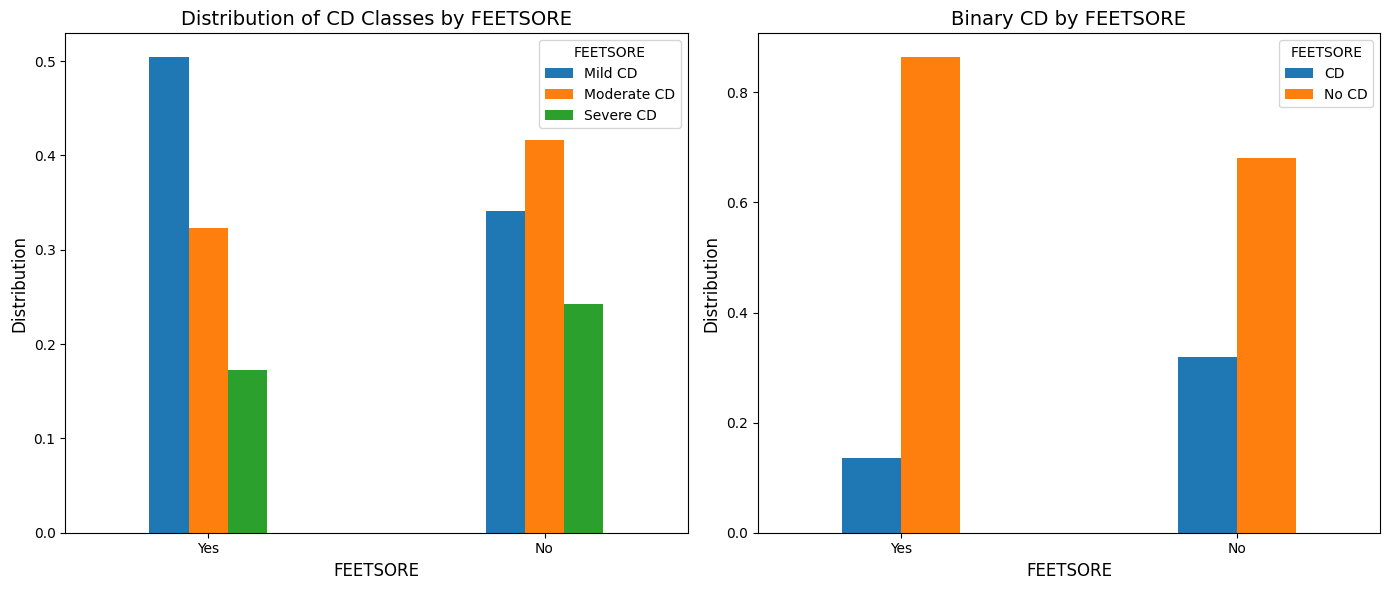

Cramers V for multi-class classification is: 0.12083708288204446
Cramers V for binary classification is: 0.1464106678552683


In [106]:
#'FEETSORE'-binary
explore_binary(df, 'FEETSORE', include_refused=False)